In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
from functools import partial
import math
from itertools import combinations

plt.rcParams['figure.figsize'] = [10, 5]


# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_SALVA = DIRETORIO_PRINCIPAL / "analise_abordagens" / "por_grupo"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"


In [2]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas

dataset = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")

abordagem = 'medidas'
df_abordagem = pd.read_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1")

In [3]:
# PERÍODOS 
#      Matutino 6h-8h59       Dataset 6h-8h45
#      Diurno 9h-20h59                9h-20h45
#      Vespertino 21h-22h59           21h-22h45
#      Noturno 23h-05h59              23h-5h30

#matutino = (time(6,0), time(9,0))
#diurno = (time(9,0), time(21,0))
#vespertino = (time(21,0), time(1,0))
#noturno = (time(1,0), time(6,0))
#
# Valores de Referência Normal das Sistólicas e Diastólicas
max_sist = 140
min_sist = 100
max_diast = 90
min_diast = 60


In [4]:

# Conta a quantidade de Picos = medidas acima do valor de referência

def conta_picos (df, qtd_medidas ,sist_max=140, sist_min=100, diast_max=90, diast_min=60) :
    sist = df.loc[:,'sist 9:00':'sist 8:45']
    diast = df.loc[:,'diast 9:00':'diast 8:45']
    
    saida = pd.DataFrame()
    saida2 = pd.DataFrame()
    contador = 0  
    
    for medida in range(0, len(sist.columns)):
        if contador == 0 :
            ls_sist_max = list()
            ls_sist_min = list()
            ls_sist_nor = list()
            
            if medida >= 56 and medida <= 69 :  
                dia_noite = int(qtd_medidas / 2)
            else :
                dia_noite = qtd_medidas
                
            contador = dia_noite - 1
            colunas = list(sist.iloc[:,medida:medida + dia_noite].columns)
            for linha in sist.iloc[:,medida:medida + dia_noite].values:
                qtd_max = 0
                qtd_min = 0
                qtd_nor = 0
                for i in range(len(linha)):
                    if linha[i] > sist_max:
                        qtd_max += 1
                    elif linha[i] < sist_min:
                        qtd_min += 1
                    else:
                        qtd_nor += 1
                        
                ls_sist_max.append(qtd_max)
                ls_sist_min.append(qtd_min)
                ls_sist_nor.append(qtd_nor)

            nome = 'Sist ' + colunas[0].split(' ')[1] + ' - ' + colunas[-1].split(' ')[1]

            saida[f'{nome} Max'] = ls_sist_max
            saida[f'{nome} Min'] = ls_sist_min
            saida[f'{nome} Normal'] = ls_sist_nor
            
            saida2[f'{nome} Max'] = ls_sist_max
            saida2[f'{nome} Min'] = ls_sist_min
        else : 
            contador -= 1
            
        
    for medida in range(0, len(diast.columns)):
        if contador == 0 :
            ls_diast_max = list()
            ls_diast_min = list()
            ls_diast_nor = list()

            if medida >= 56 and medida <= 69 :  
                dia_noite = int(qtd_medidas / 2)
            else :
                dia_noite = qtd_medidas
            contador = dia_noite - 1
            colunas = list(diast.iloc[:,medida:medida + dia_noite].columns)
            for linha in diast.iloc[:,medida:medida + dia_noite].values:
                qtd_max = 0
                qtd_min = 0
                qtd_nor = 0
                for i in range(len(linha)):
                    if linha[i] > diast_max:
                        qtd_max += 1
                    elif linha[i] < diast_min:
                        qtd_min += 1
                    else:
                        qtd_nor += 1
                        
                ls_diast_max.append(qtd_max)
                ls_diast_min.append(qtd_min)
                ls_diast_nor.append(qtd_nor)

            nome = 'Diast ' + colunas[0].split(' ')[1] + ' - ' + colunas[-1].split(' ')[1]

            saida[f'{nome} Max'] = ls_diast_max
            saida[f'{nome} Min'] = ls_diast_min
            saida[f'{nome} Normal'] = ls_diast_nor
            
            saida2[f'{nome} Max'] = ls_diast_max
            saida2[f'{nome} Min'] = ls_diast_min
        else : 
            contador -= 1
        
    return saida, saida2
 
def comb(n,k):
    return int(math.factorial(n) / (math.factorial(k)*math.factorial(n - k)))


In [5]:
def conta_picos_por_horario (df ,sist_max=140, sist_min=100, diast_max=90, diast_min=60) :
    sist = df.loc[:,'sist 9:00':'sist 8:45']
    diast = df.loc[:,'diast 9:00':'diast 8:45']
    
    horarios = [horario.split(' ')[1] for horario in list(df.loc[:,'diast 9:00':'diast 8:45'].columns)]
    
    saida = pd.DataFrame()
    saida2 = pd.DataFrame()
    saida3 = pd.DataFrame()
    
    ls_sist_max = list()
    ls_sist_min = list()
    ls_sist_nor = list()
    ls_sist_picos = list()
    
    for coluna in range(0, len(sist.columns)):
        qtd_max = 0
        qtd_min = 0
        qtd_nor = 0       
        for linha in sist.iloc[:,coluna].values:

            if linha > sist_max:
                qtd_max += 1
            elif linha < sist_min:
                qtd_min += 1
            else:
                qtd_nor += 1
        ls_sist_max.append(qtd_max)
        ls_sist_min.append(qtd_min)
        ls_sist_nor.append(qtd_nor)
        ls_sist_picos.append(qtd_max + qtd_min)
        
        
    ls_diast_max = list()
    ls_diast_min = list()
    ls_diast_nor = list()
    ls_diast_picos = list()
    for coluna in range(0, len(diast.columns)):
        qtd_max = 0
        qtd_min = 0
        qtd_nor = 0       
        for linha in diast.iloc[:,coluna].values:

            if linha > diast_max:
                qtd_max += 1
            elif linha < diast_min:
                qtd_min += 1
            else:
                qtd_nor += 1
        ls_diast_max.append(qtd_max)
        ls_diast_min.append(qtd_min)
        ls_diast_nor.append(qtd_nor)
        ls_diast_picos.append(qtd_max + qtd_min)
    
    
    saida['Horário'] = horarios
    saida2['Horário'] = horarios
    saida3['Horário'] = horarios
    
    
    nome = 'Sist'

    saida[f'{nome} Max'] = ls_sist_max
    saida[f'{nome} Min'] = ls_sist_min
    saida[f'{nome} Normal'] = ls_sist_nor

    saida2[f'{nome} Max'] = ls_sist_max
    saida2[f'{nome} Min'] = ls_sist_min
    
    nome = 'Diast'

    saida[f'{nome} Max'] = ls_diast_max
    saida[f'{nome} Min'] = ls_diast_min
    saida[f'{nome} Normal'] = ls_diast_nor

    saida2[f'{nome} Max'] = ls_diast_max
    saida2[f'{nome} Min'] = ls_diast_min
    
    saida3['% sist'] = np.round(np.array(ls_sist_picos) / np.sum(ls_sist_picos) * 100, 2)
    saida3['% diast'] = np.round(np.array(ls_diast_picos) / np.sum(ls_diast_picos) * 100, 2)

    return saida, saida2, saida3

In [6]:
saida,saida2,saida3 = conta_picos_por_horario(dataset)

In [7]:
saida2

,Horário,Sist Max,Sist Min,Diast Max,Diast Min
0,9:00,3621,847,4293,1061
1,9:15,3767,805,4403,1016
2,9:30,3781,739,4393,982
3,9:45,3703,753,4420,975
4,10:00,3633,784,4485,979
...,...,...,...,...,...
77,7:45,3352,1202,3838,1641
78,8:00,3450,1060,4005,1422
79,8:15,3560,998,4114,1307
80,8:30,3600,928,4171,1218


In [8]:
#  Calcula a qtd de picos e organiza em forma descendente
# Informa à função o dataset e quantas medidas considerar. A cada 4, significa 1h de medidas diurnas

contagem_picos = conta_picos(dataset,4)[0]
ls_valores = list()
for i in range(len(contagem_picos)) :
    ls_valores.append(sum(contagem_picos.iloc[i,:]))
novo_dataset = pd.DataFrame ()
novo_dataset['numero_identificacao'] = dataset['numero_identificacao']
novo_dataset ['qtd picos'] = ls_valores
novo_dataset = novo_dataset.sort_values(by=['qtd picos'], ascending=False)

In [9]:
def coluna_hora(horario):
    return float(horario.split(' ')[1].replace(':','.'))

In [10]:
#   Verifica quantitativo de picos e % em relação ao total de picos de cada grupo
#
def conta_picos_df(df,abordagem):
    lista_grupos = list()
    df_geral = pd.DataFrame()
    for j in range(len(set(df['grupo']))):
        df_grupo = df[df['grupo'] == j+1]
        contagem_picos, contagem_picos2 = conta_picos(df_grupo,4)
        
       # ls_valores = list()
       # for i in range(len(contagem_picos)) :
       #     ls_valores.append(sum(contagem_picos.iloc[i,:]))
       # novo_dataset = pd.DataFrame ()
        #novo_dataset['numero_identificacao'] = df_grupo['numero_identificacao']
        #novo_dataset ['qtd picos'] = ls_valores
        #novo_dataset = novo_dataset.sort_values(by=['qtd picos'], ascending=False)
        
        qtd_total_picos = np.sum(contagem_picos,axis=0).sort_values(ascending=False)
        qtd_total_picos = qtd_total_picos.to_frame().reset_index()
        qtd_total_picos.columns = ['Horário',f'QTD - Grupo {j+1}']
        qtd_total_picos['% no Grupo'] = np.round(qtd_total_picos[f'QTD - Grupo {j+1}'] / sum(qtd_total_picos[f'QTD - Grupo {j+1}']) * 100,3)
        qtd_total_picos['hora'] = qtd_total_picos['Horário'].apply(coluna_hora)
        qtd_total_picos = qtd_total_picos.sort_values(by=['hora','Horário'], ascending = True)
        qtd_total_picos = qtd_total_picos.drop(['hora'],axis=1)
        qtd_total_picos_aux = qtd_total_picos.sort_values(by='% no Grupo', ascending=False)
        #qtd_total_picos.to_csv ( DIR_SALVA / f"frequencia_picos_{abordagem}_grupo{j+1}.csv", sep=";", encoding="latin1")
        qtd_total_picos_aux.to_excel ( DIR_SALVA / f"frequencia_picos_{abordagem}_grupo{j+1}.xlsx", index = False)
        
        aux = np.sum(contagem_picos2,axis=0).sort_values(ascending=False)
        aux = aux.to_frame().reset_index()
        aux.columns = [f'Horário - Grupo {j+1}',f'QTD - Grupo {j+1}']
        df_geral[f'Horário - Grupo {j+1}'] = aux[f'Horário - Grupo {j+1}'].values
        df_geral[f'QTD - Grupo {j+1}'] = aux[f'QTD - Grupo {j+1}']
        lista_grupos.append(qtd_total_picos)
    df_geral.to_excel ( DIR_SALVA / f"frequencia_picos_comparativo_{abordagem}.xlsx", index = False)
    return lista_grupos, df_geral


In [11]:
lista_contagem,qtd_picos  = conta_picos_df(df_abordagem,'medidas')

In [12]:
qtd_picos

,Horário - Grupo 1,QTD - Grupo 1,Horário - Grupo 2,QTD - Grupo 2,Horário - Grupo 3,QTD - Grupo 3,Horário - Grupo 4,QTD - Grupo 4,Horário - Grupo 5,QTD - Grupo 5,Horário - Grupo 6,QTD - Grupo 6,Horário - Grupo 7,QTD - Grupo 7
0,Sist 6:00 - 6:45 Min,2958,Sist 19:00 - 19:45 Max,2505,Diast 22:00 - 22:45 Min,2692,Diast 10:00 - 10:45 Max,6199,Diast 10:00 - 10:45 Max,6252,Diast 6:00 - 6:45 Min,4771,Sist 7:00 - 7:45 Max,3466
1,Diast 6:00 - 6:45 Min,2785,Sist 8:00 - 8:45 Max,2463,Diast 6:00 - 6:45 Min,2483,Diast 11:00 - 11:45 Max,6085,Diast 11:00 - 11:45 Max,6061,Diast 22:00 - 22:45 Min,4553,Sist 8:00 - 8:45 Max,3450
2,Diast 2:00 - 2:30 Min,2580,Sist 20:00 - 20:45 Max,2460,Diast 14:00 - 14:45 Min,2395,Diast 9:00 - 9:45 Max,5885,Diast 9:00 - 9:45 Max,6030,Sist 6:00 - 6:45 Min,3812,Sist 9:00 - 9:45 Max,3368
3,Diast 1:00 - 1:30 Min,2559,Sist 18:00 - 18:45 Max,2455,Diast 1:00 - 1:30 Min,2333,Diast 12:00 - 12:45 Max,5719,Diast 18:00 - 18:45 Max,5892,Diast 3:00 - 3:30 Min,3602,Sist 19:00 - 19:45 Max,3170
4,Diast 3:00 - 3:30 Min,2485,Sist 9:00 - 9:45 Max,2444,Diast 2:00 - 2:30 Min,2259,Diast 8:00 - 8:45 Max,5426,Diast 19:00 - 19:45 Max,5807,Diast 2:00 - 2:30 Min,3590,Sist 20:00 - 20:45 Max,3048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Sist 5:00 - 5:30 Max,52,Sist 4:00 - 4:30 Min,5,Diast 23:00 - 23:30 Max,54,Sist 20:00 - 20:45 Min,176,Sist 21:00 - 21:45 Min,40,Diast 4:00 - 4:30 Max,10,Sist 21:00 - 21:45 Min,55
92,Sist 1:00 - 1:30 Max,47,Sist 6:00 - 6:45 Min,4,Diast 4:00 - 4:30 Max,50,Diast 12:00 - 12:45 Min,159,Diast 11:00 - 11:45 Min,38,Diast 2:00 - 2:30 Max,9,Sist 5:00 - 5:30 Min,48
93,Sist 4:00 - 4:30 Max,37,Sist 5:00 - 5:30 Min,4,Diast 1:00 - 1:30 Max,45,Sist 19:00 - 19:45 Min,150,Diast 17:00 - 17:45 Min,33,Diast 3:00 - 3:30 Max,7,Sist 4:00 - 4:30 Min,48
94,Sist 3:00 - 3:30 Max,33,Sist 2:00 - 2:30 Min,4,Diast 2:00 - 2:30 Max,44,Diast 10:00 - 10:45 Min,149,Sist 20:00 - 20:45 Min,30,Diast 1:00 - 1:30 Max,6,Sist 23:00 - 23:30 Min,46


In [13]:
def percentual_por_horario_grupo(df, abordagem):
    ls_grupos_percent = list()
    ls_grupos_qtd = list()

# Em cada horário calcula o % das medidas (PAS e PAD) em relação ao tipo (normal, acima ou abaixo do VR) plotando 
# em 3 gráficos, sendo 1 de cada tipo
#
    for i in range(len(set(df['grupo']))):
        df_grupo = df[df['grupo'] == i+1]
        contagem, contagem1, contagem2 = conta_picos_por_horario(df_grupo)
        
        df_percentual = pd.DataFrame()
        df_percentual[f'Horário - Grupo {i + 1}'] = contagem['Horário']
        
        df_percentual['% Sist Max'] = np.round(contagem['Sist Max'] / 
                                              np.sum(contagem['Sist Max']) * 100, 2)
        
        df_percentual['% Sist Min'] = np.round(contagem['Sist Min'] / 
                                              np.sum(contagem['Sist Min']) * 100, 2)
        
        df_percentual['% Sist Normal'] = np.round(contagem['Sist Normal'] / 
                                              np.sum(contagem['Sist Normal']) * 100, 2)
        
        df_percentual['% Diast Max'] = np.round(contagem['Diast Max'] / 
                                              np.sum(contagem['Diast Max']) * 100, 2)
        
        df_percentual['% Diast Min'] = np.round(contagem['Diast Min'] / 
                                              np.sum(contagem['Diast Min']) * 100, 2)
        
        df_percentual['% Diast Normal'] = np.round(contagem['Diast Normal'] / 
                                              np.sum(contagem['Diast Normal']) * 100, 2)
        ls_grupos_percent.append(df_percentual)
        
        contagem.columns = [f'Horário - Grupo {i + 1}',
                             'Sist Max',
                             'Sist Min',
                             'Sist Normal',
                             'Diast Max',
                             'Diast Min',
                             'Diast Normal']
        
        ls_grupos_qtd.append(contagem)
        df_percentual.to_excel ( DIR_SALVA / f"percentual_tipos_pressao_grupo{i+1}_abordagem_{abordagem}.xlsx", index = False)
        contagem.to_excel ( DIR_SALVA / f"qtd_tipos_pressao_grupo{i+1}_abordagem_{abordagem}.xlsx", index = False)
    return ls_grupos_percent, ls_grupos_qtd

In [14]:
ls_grupos_p, ls_grupos_qtd = percentual_por_horario_grupo(df_abordagem, 'medidas')

In [15]:
lista_contagem[6].head(10)

,Horário,QTD - Grupo 7,% no Grupo
116,Diast 0:00 - 0:30 Max,191,0.067
89,Diast 0:00 - 0:30 Min,612,0.214
48,Diast 0:00 - 0:30 Normal,2691,0.939
71,Sist 0:00 - 0:30 Max,918,0.320
143,Sist 0:00 - 0:30 Min,45,0.016
56,Sist 0:00 - 0:30 Normal,2531,0.883
119,Diast 1:00 - 1:30 Max,174,0.061
88,Diast 1:00 - 1:30 Min,663,0.231
50,Diast 1:00 - 1:30 Normal,2657,0.927
77,Sist 1:00 - 1:30 Max,845,0.295


In [16]:
#float('Diast 0:00- 0:30 Max'.split(' ')[1].replace(':','.'))

In [17]:
lista_contagem[6].sort_values(by=['Horário'])

,Horário,QTD - Grupo 7,% no Grupo
116,Diast 0:00 - 0:30 Max,191,0.067
89,Diast 0:00 - 0:30 Min,612,0.214
48,Diast 0:00 - 0:30 Normal,2691,0.939
70,Diast 10:00 - 10:45 Max,1025,0.358
107,Diast 10:00 - 10:45 Min,362,0.126
...,...,...,...
127,Sist 8:00 - 8:45 Min,94,0.033
35,Sist 8:00 - 8:45 Normal,3444,1.202
36,Sist 9:00 - 9:45 Max,3368,1.176
125,Sist 9:00 - 9:45 Min,108,0.038


In [18]:
# Salva os gráficos do % de medidas fora do Valor de Referência para PAS e PAD
#
def grafico_percentual(eixo_x,eixo_y, grupo, medida, posicao):
    fig=plt.figure(figsize=(15,5))
    plt.grid(linestyle='--', linewidth = 0.5, color = 'gray')
    plt.title(f'Percentual de medidas {posicao} do valor de referência - {medida} - Grupo {grupo}', fontsize = 16)
    plt.ylabel('% no Grupo',fontsize=12)
    plt.xlabel('Horário',fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    N = len(eixo_x)

    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2 # inch margin
    s = maxsize/plt.gcf().dpi*N+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s+20, plt.gcf().get_size_inches()[1])
    
    plt.plot(eixo_x,eixo_y,'r.')
    #plt.figure(figsize=(25,10))
    plt.savefig(DIR_SALVA / "graficos" / f'grafico_qtd_medidas_{posicao}_{medida}_grupo{grupo}.svg',
               bbox_inches="tight", pad_inches=1)
    plt.show()

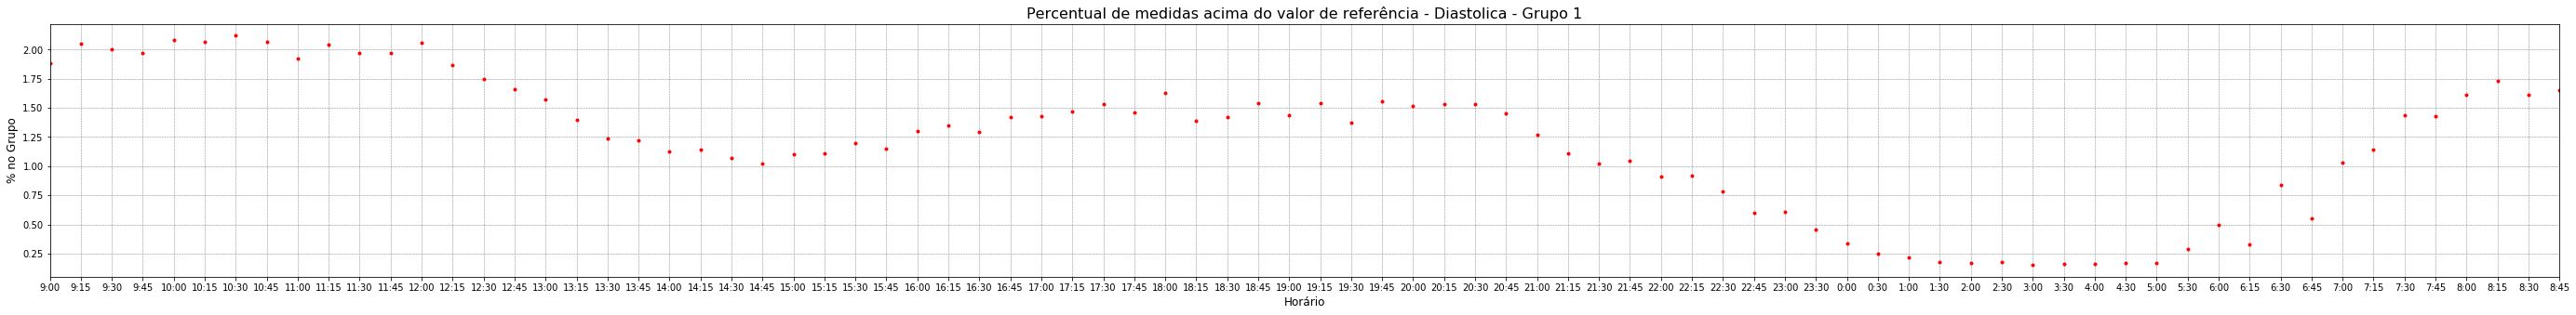

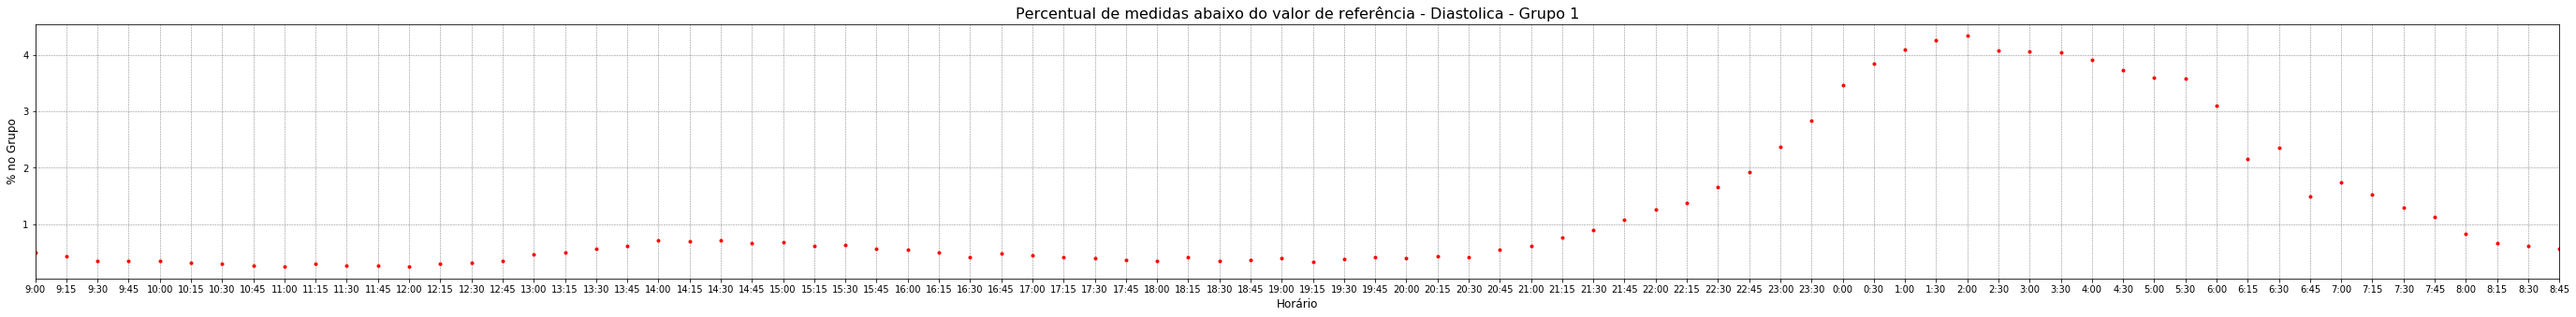

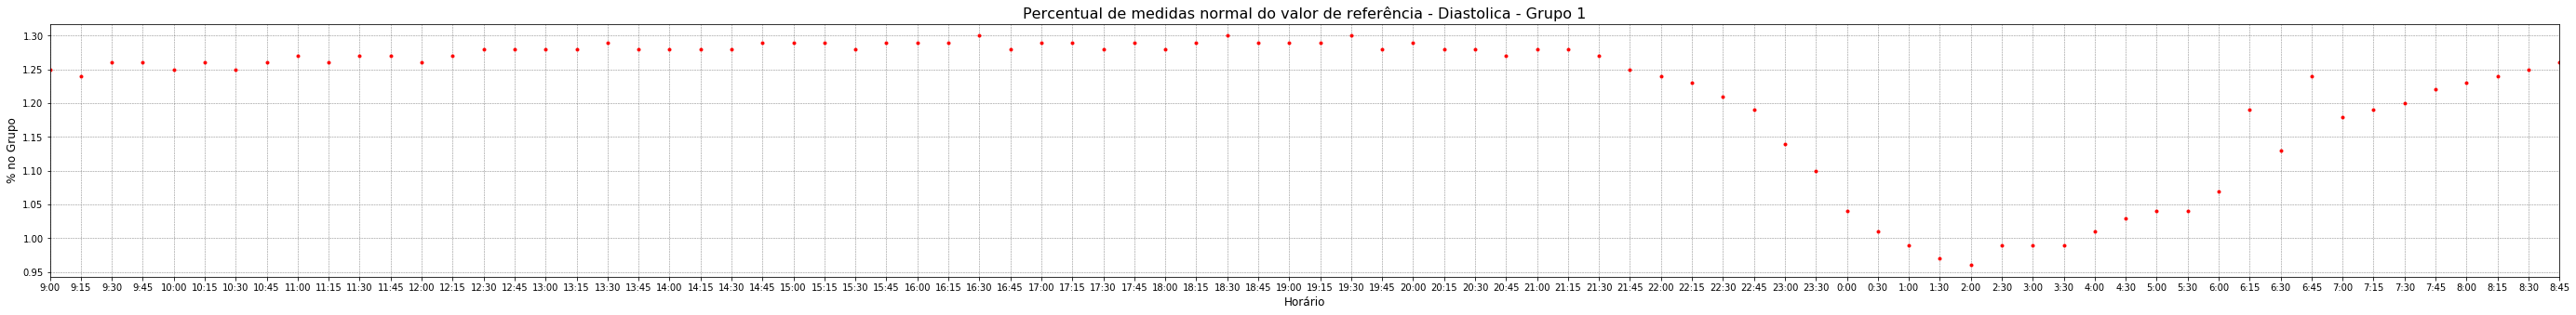

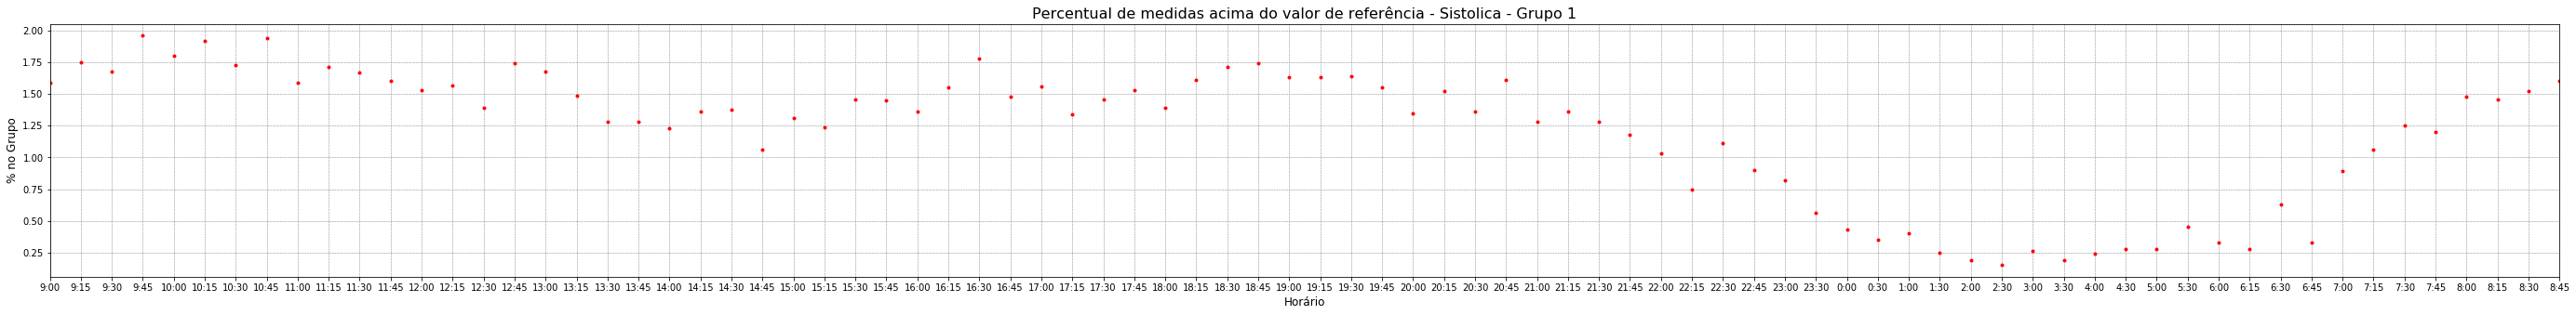

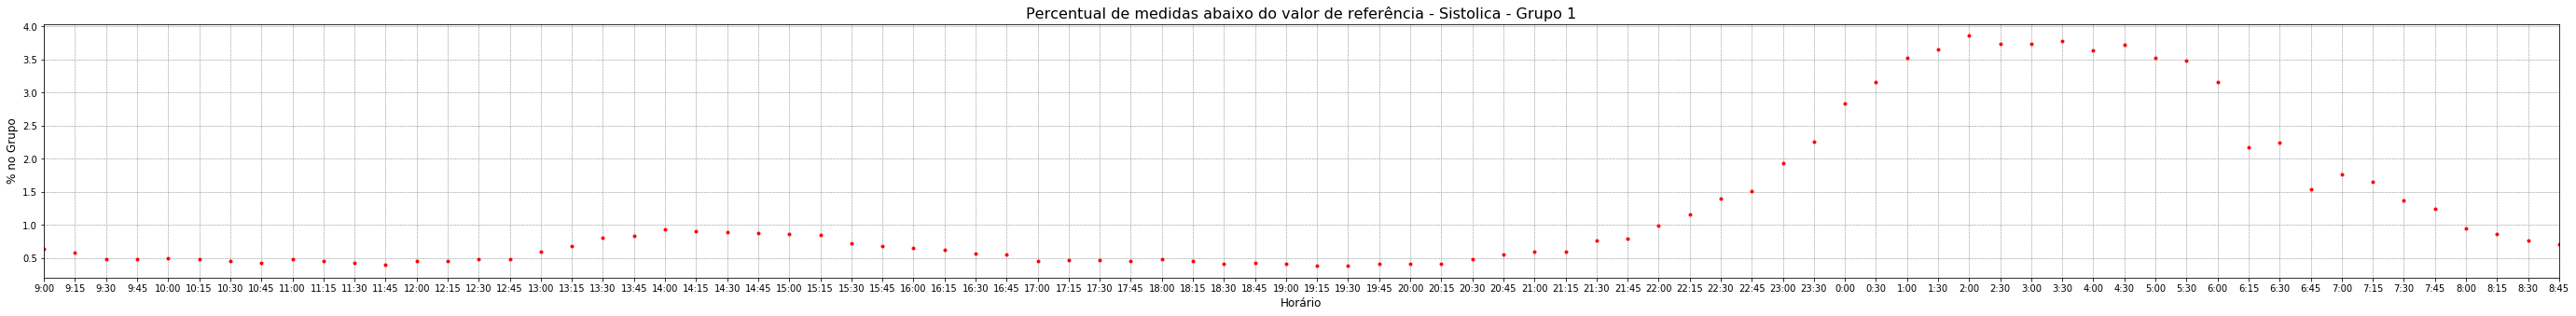

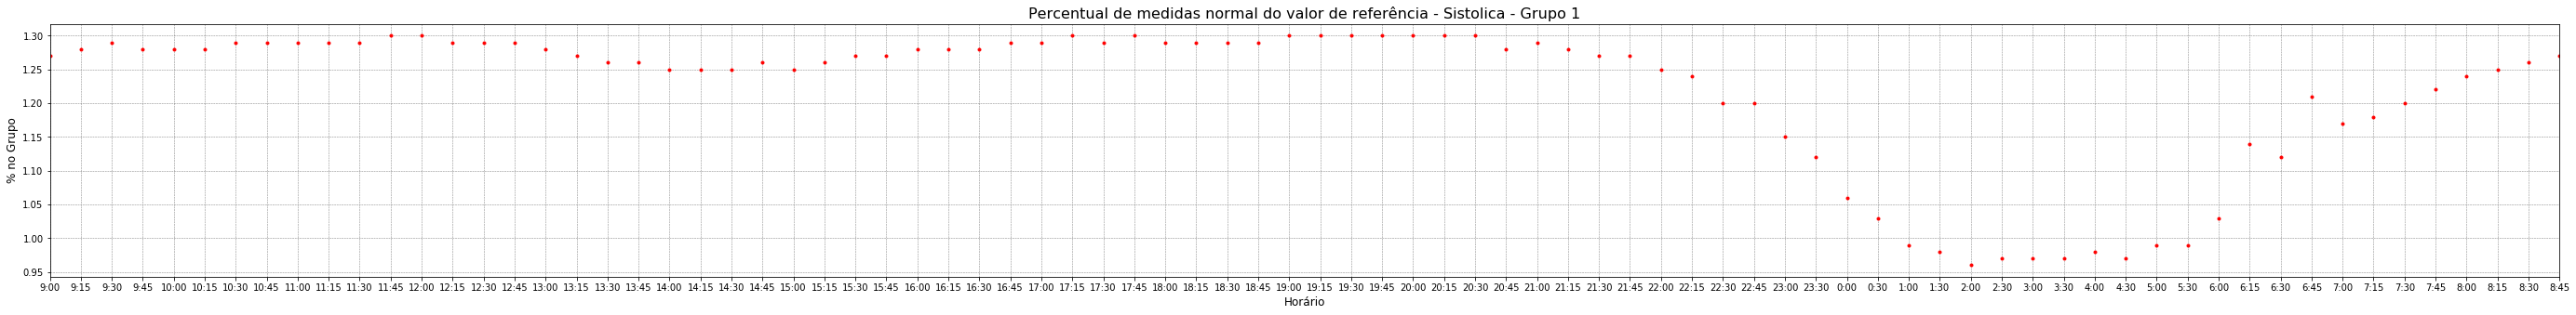

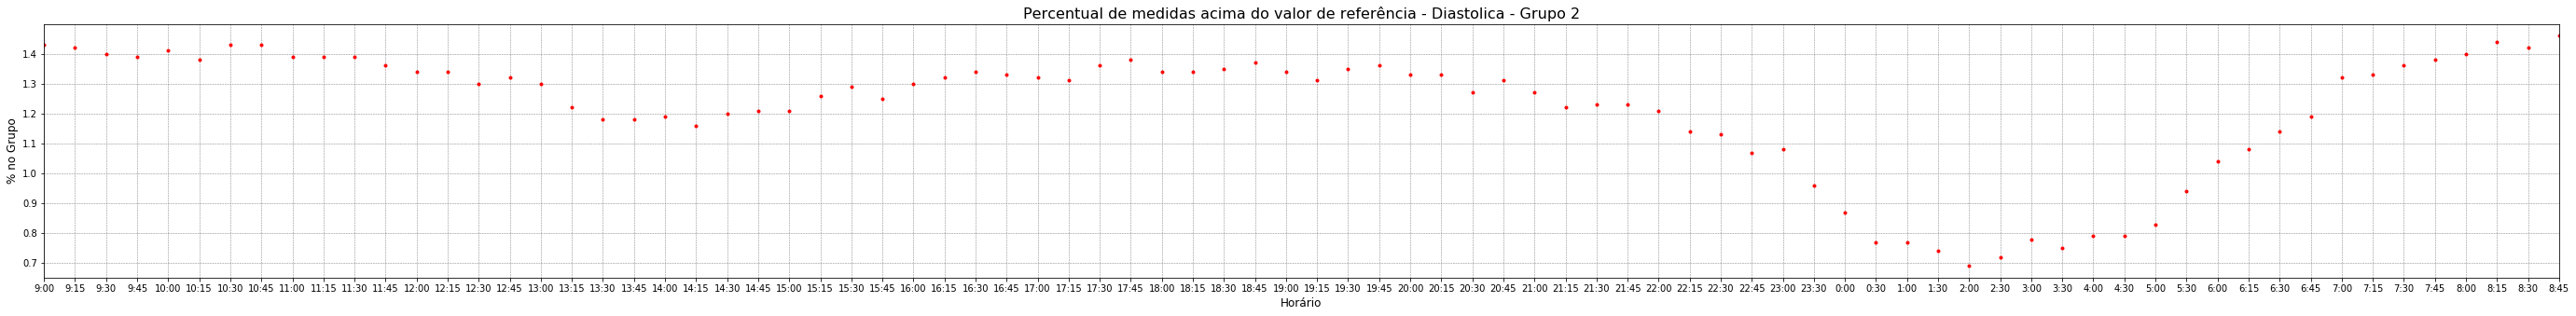

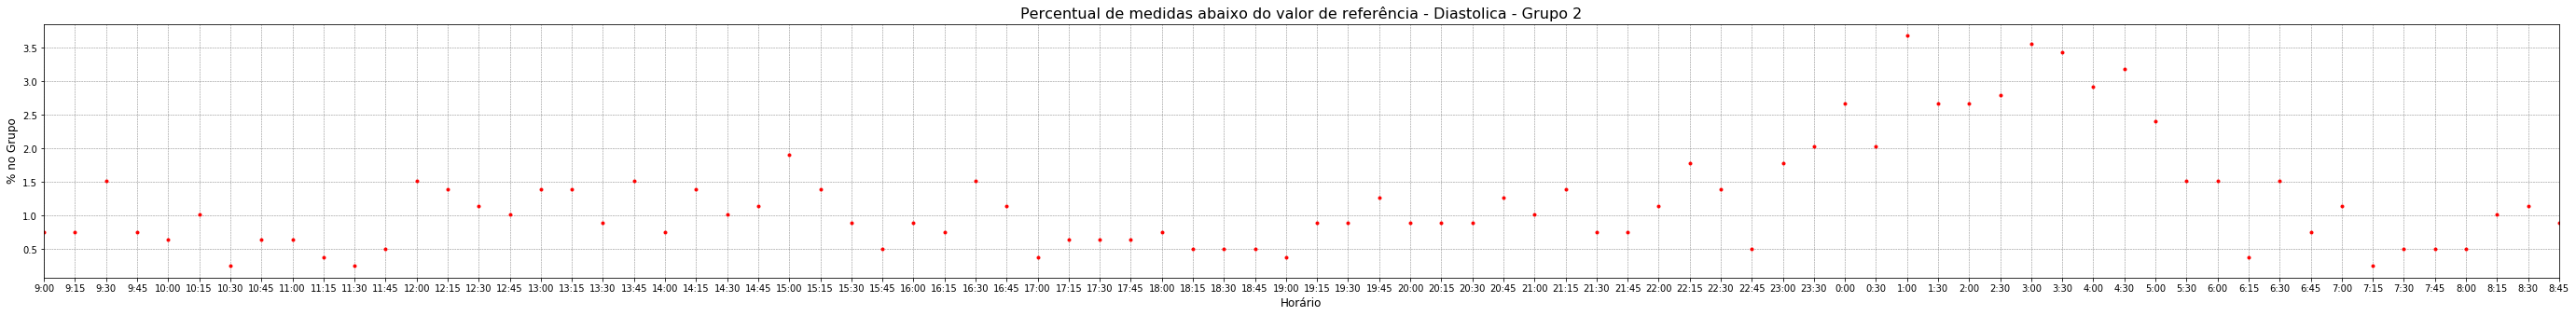

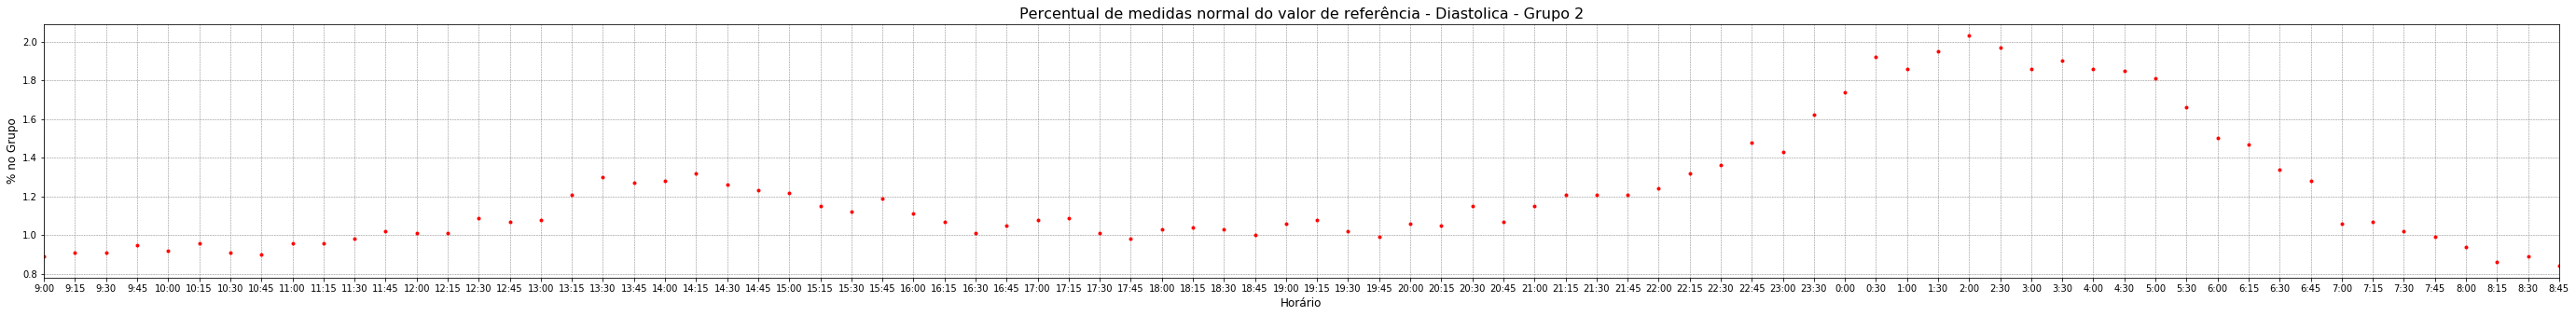

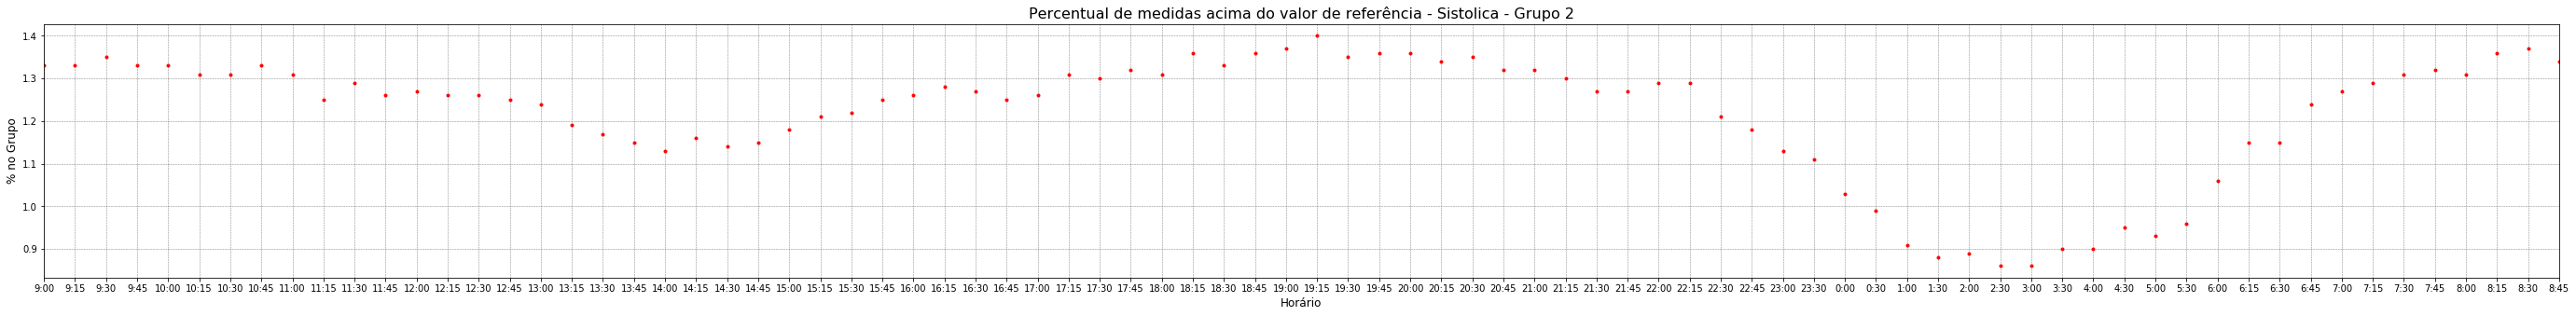

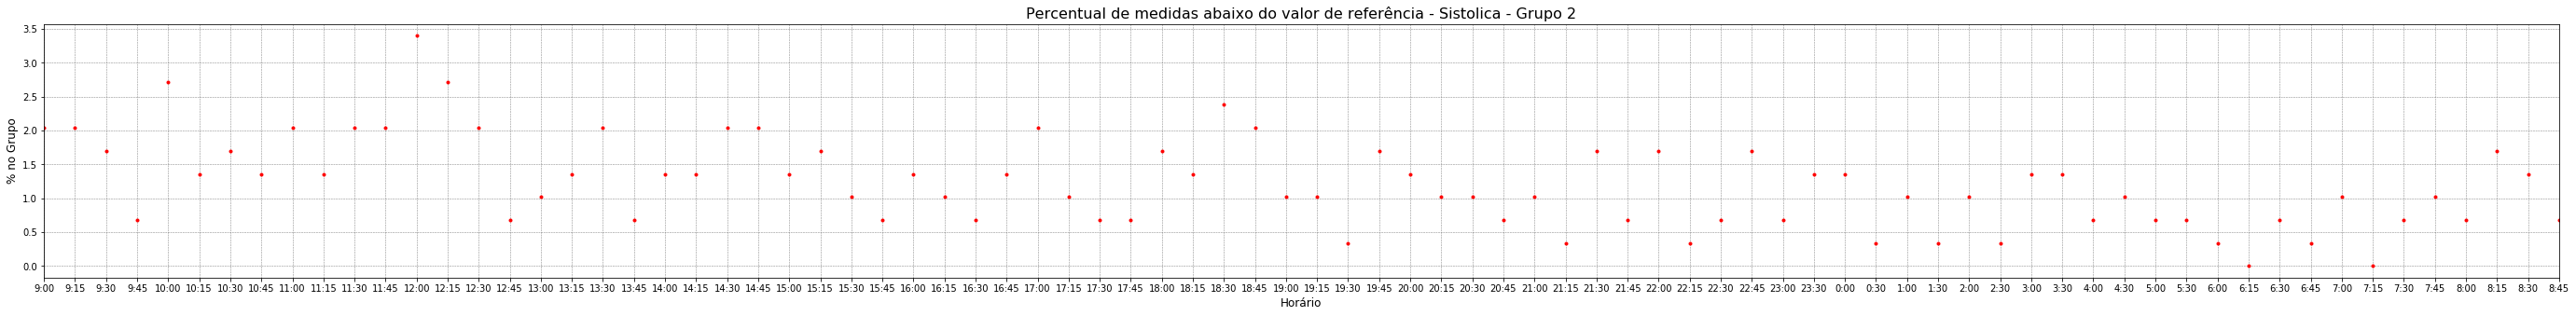

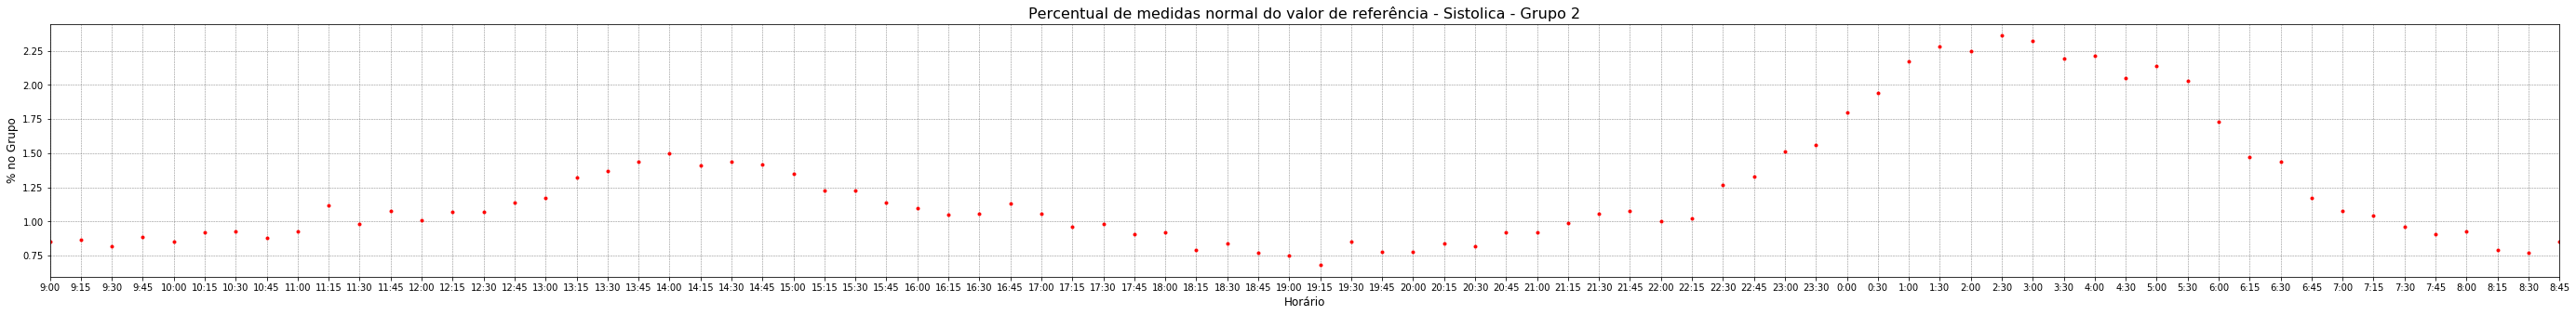

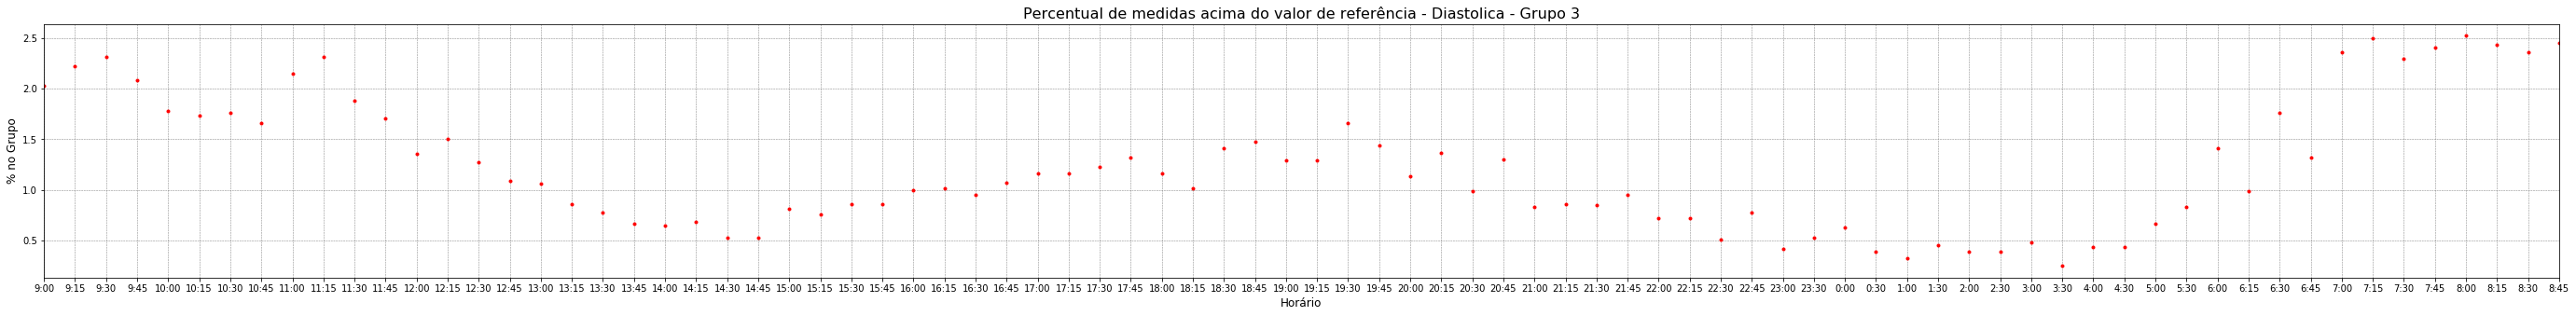

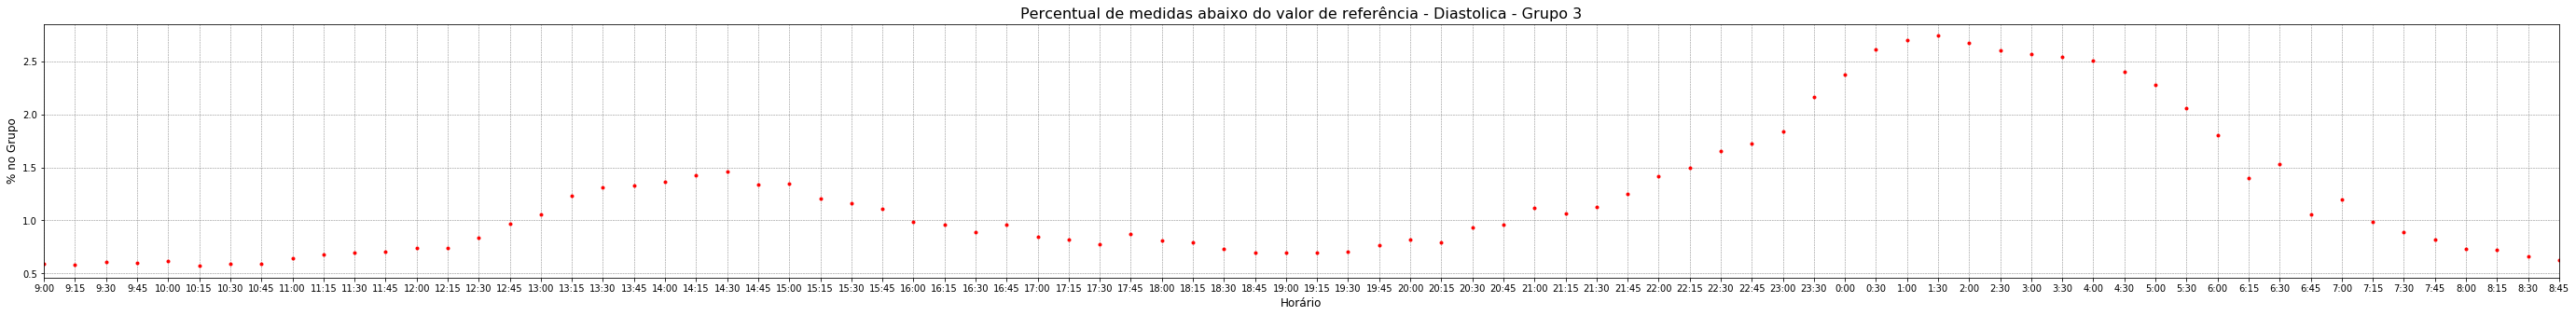

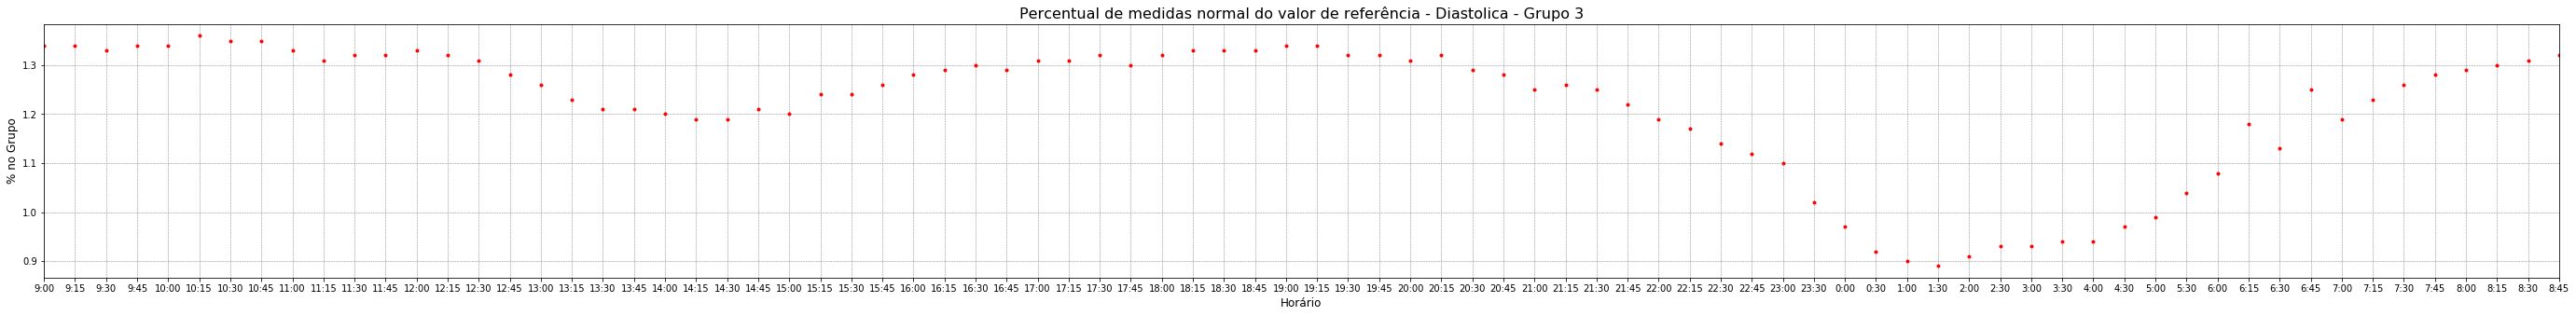

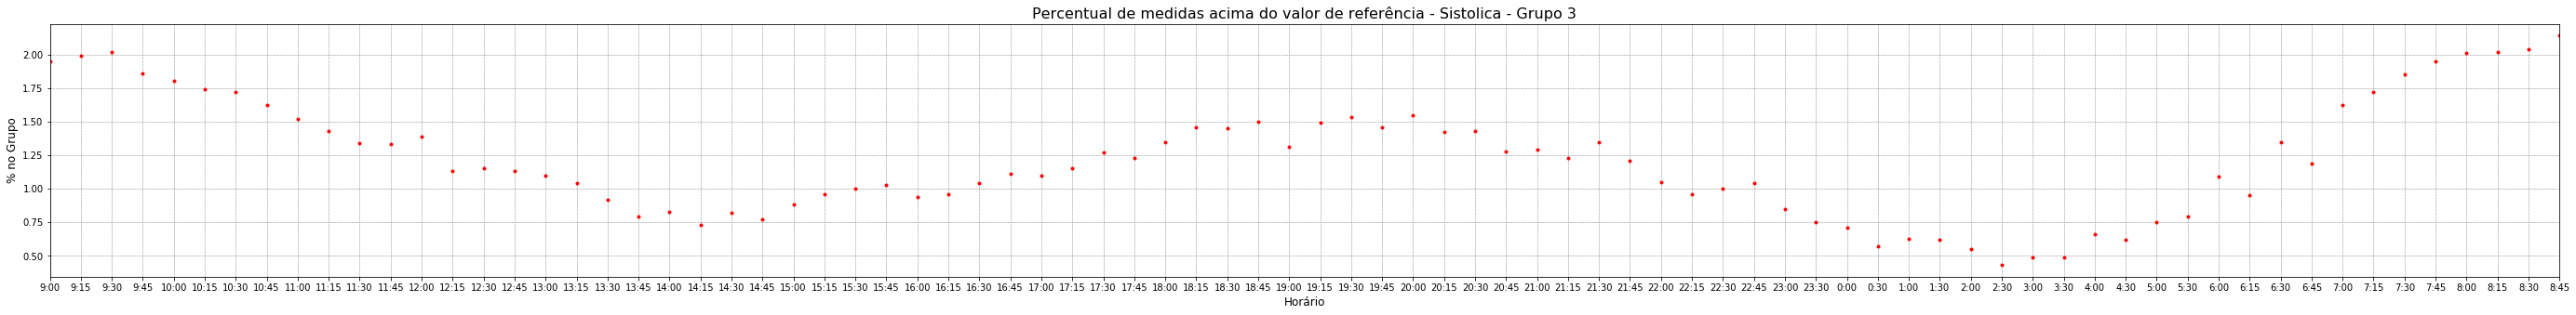

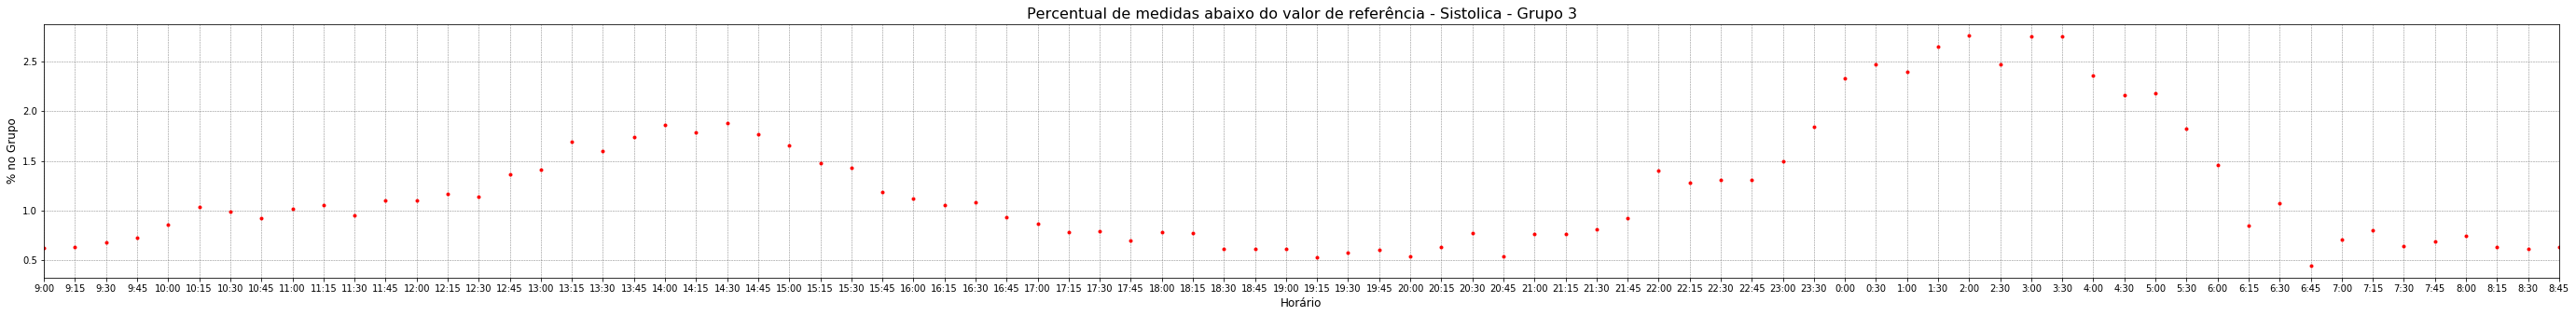

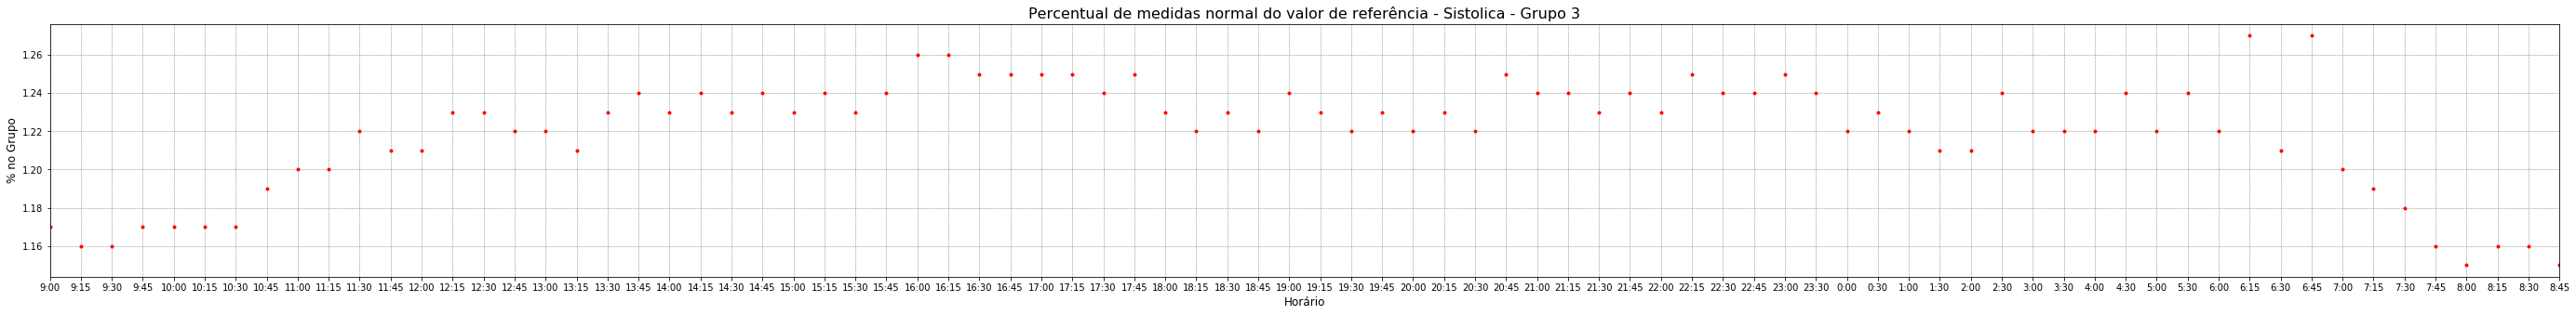

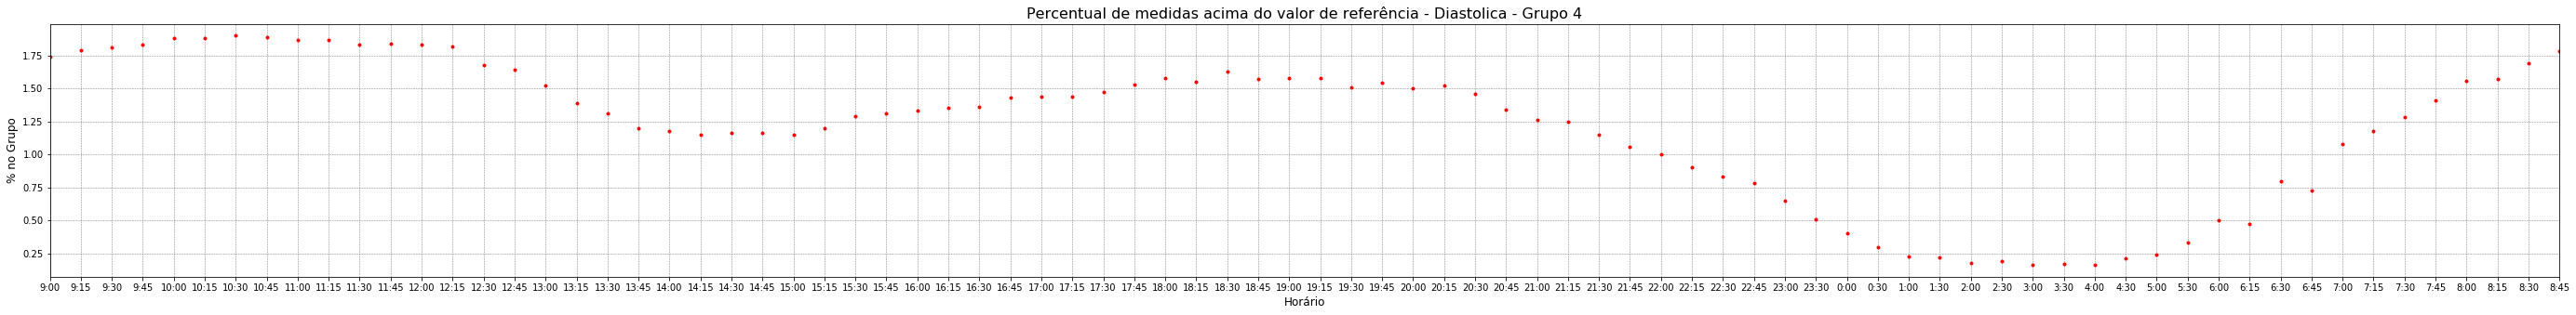

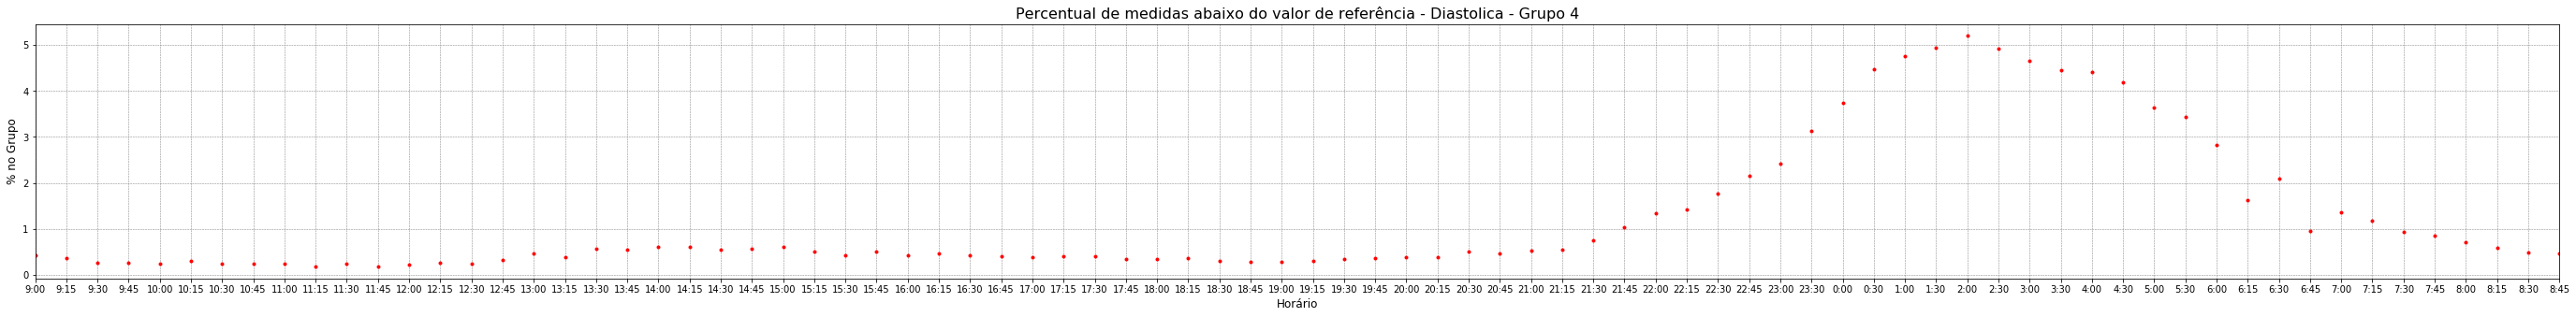

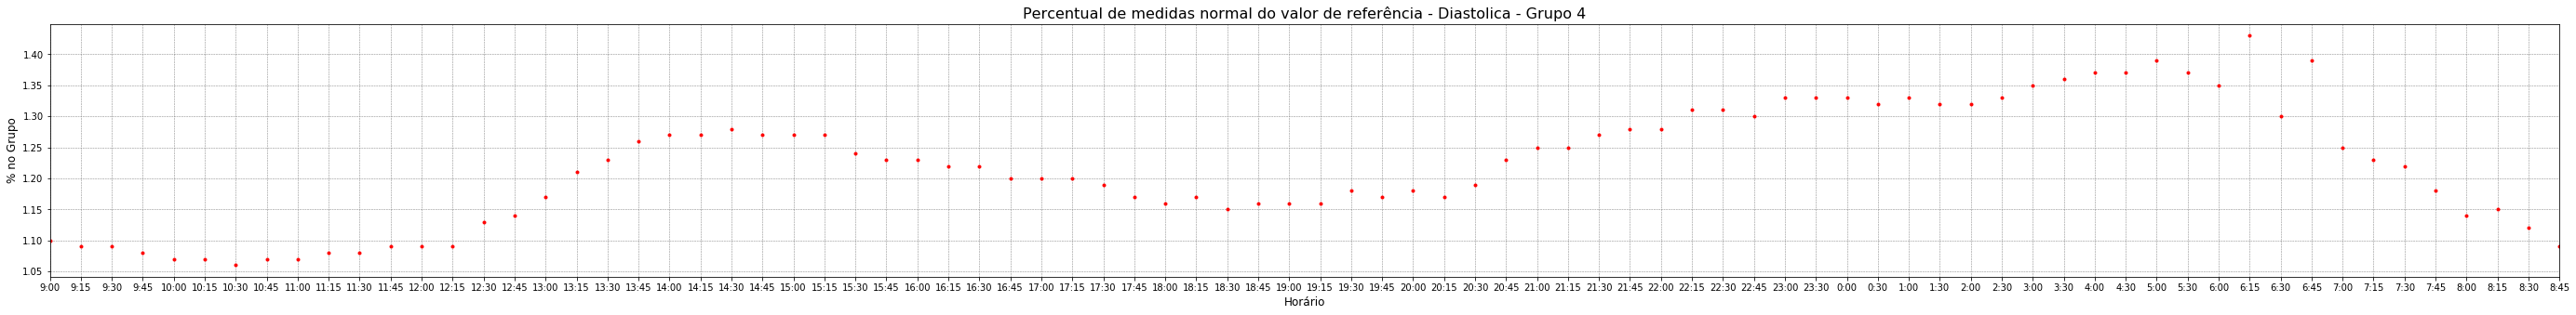

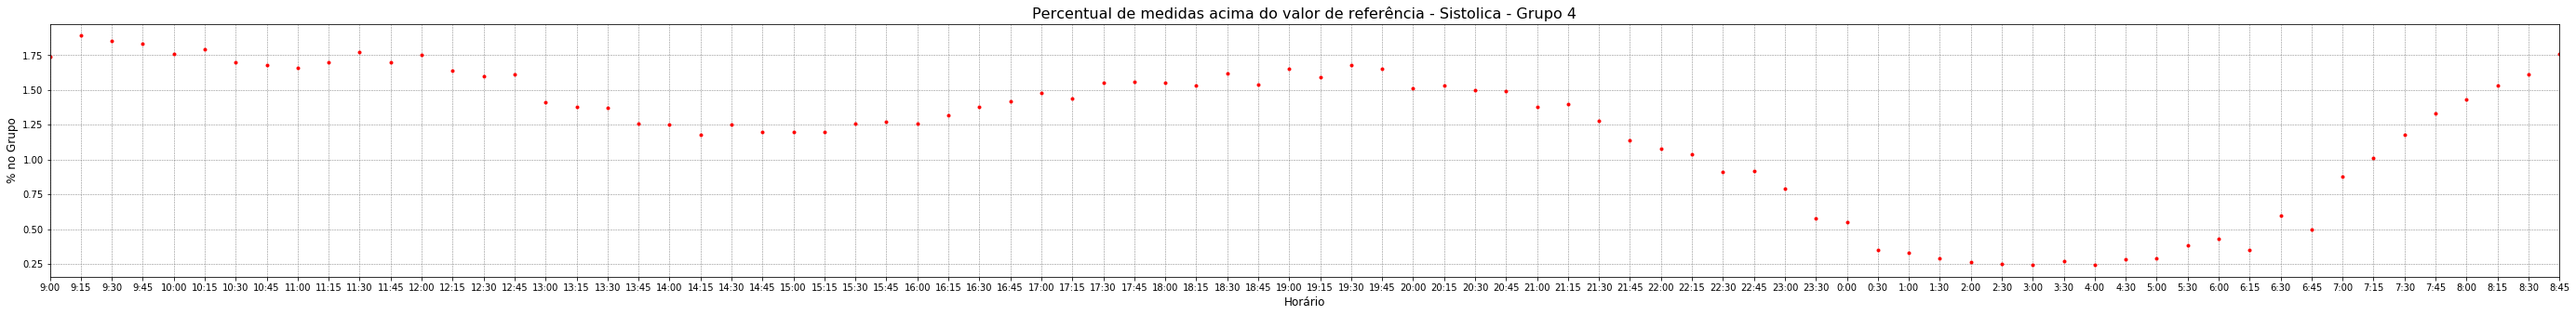

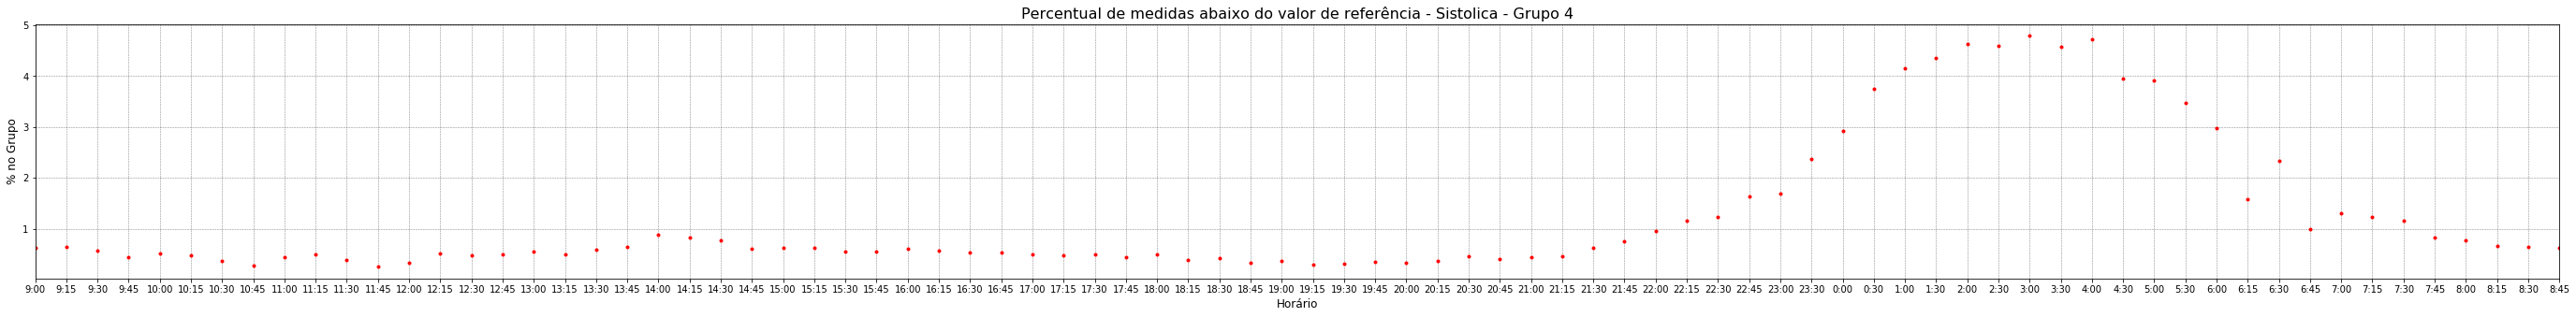

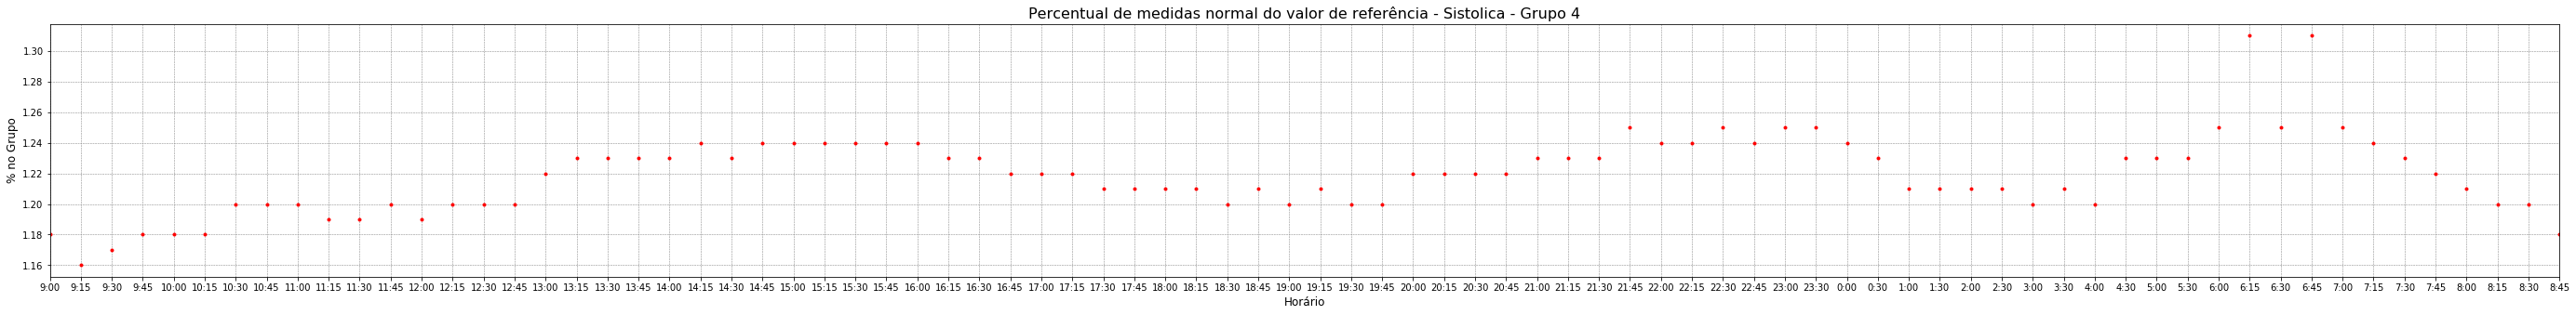

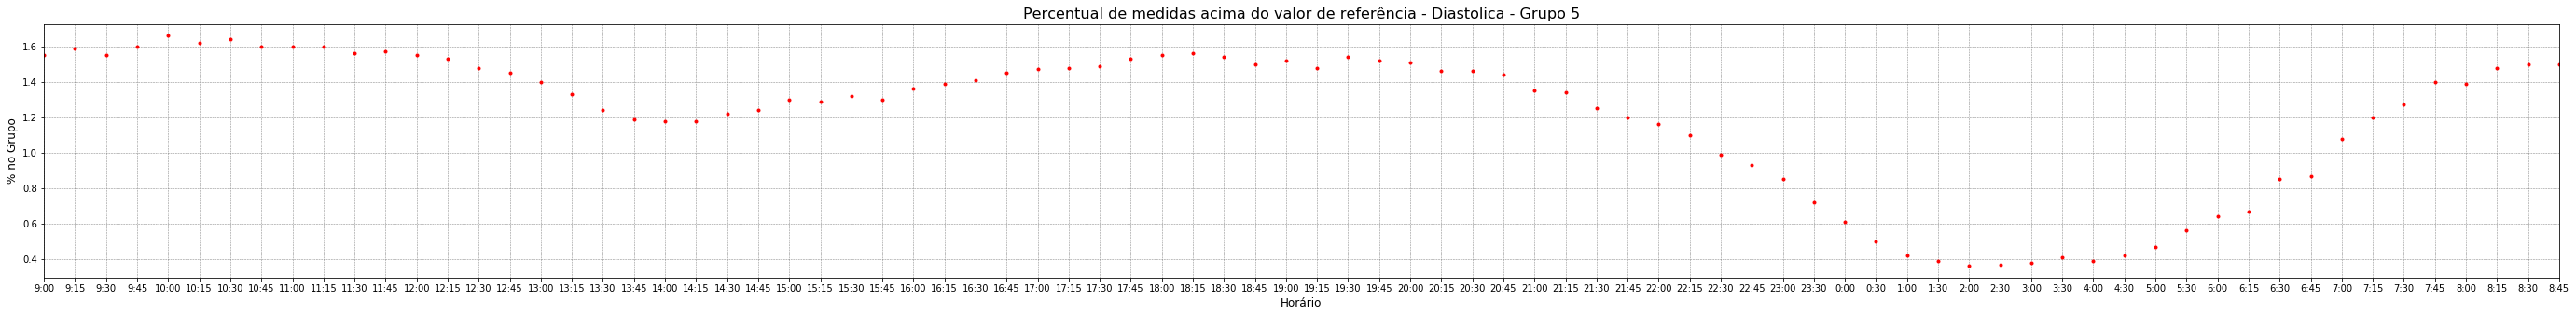

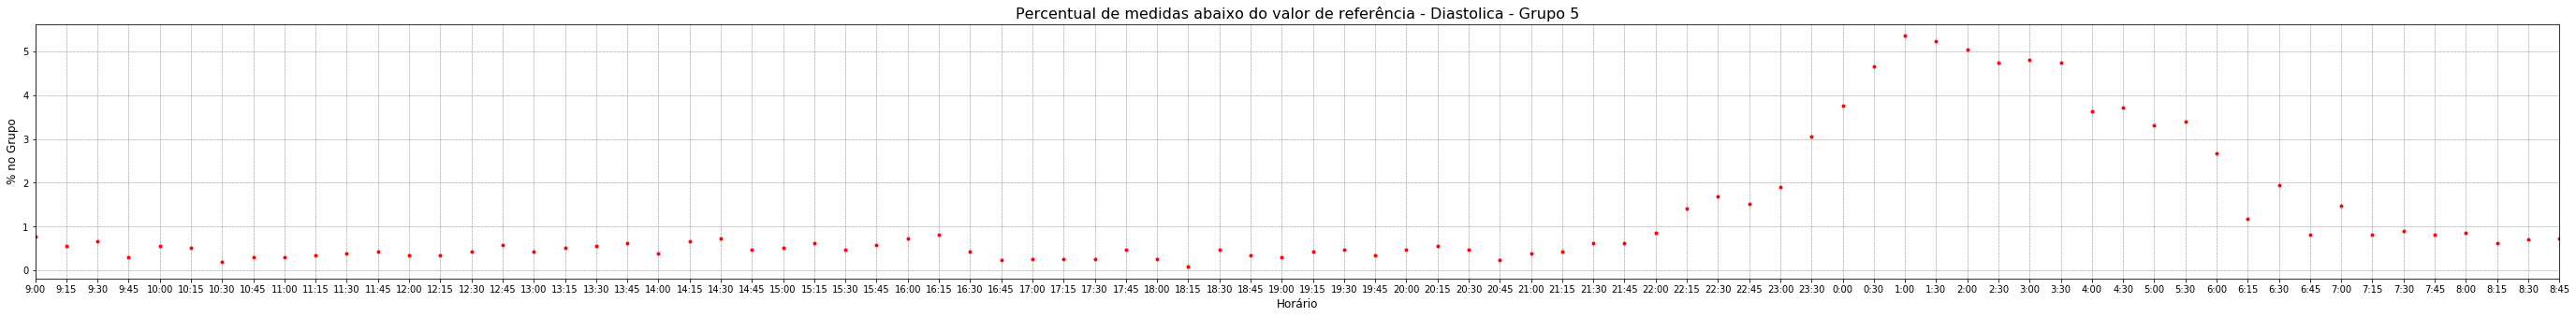

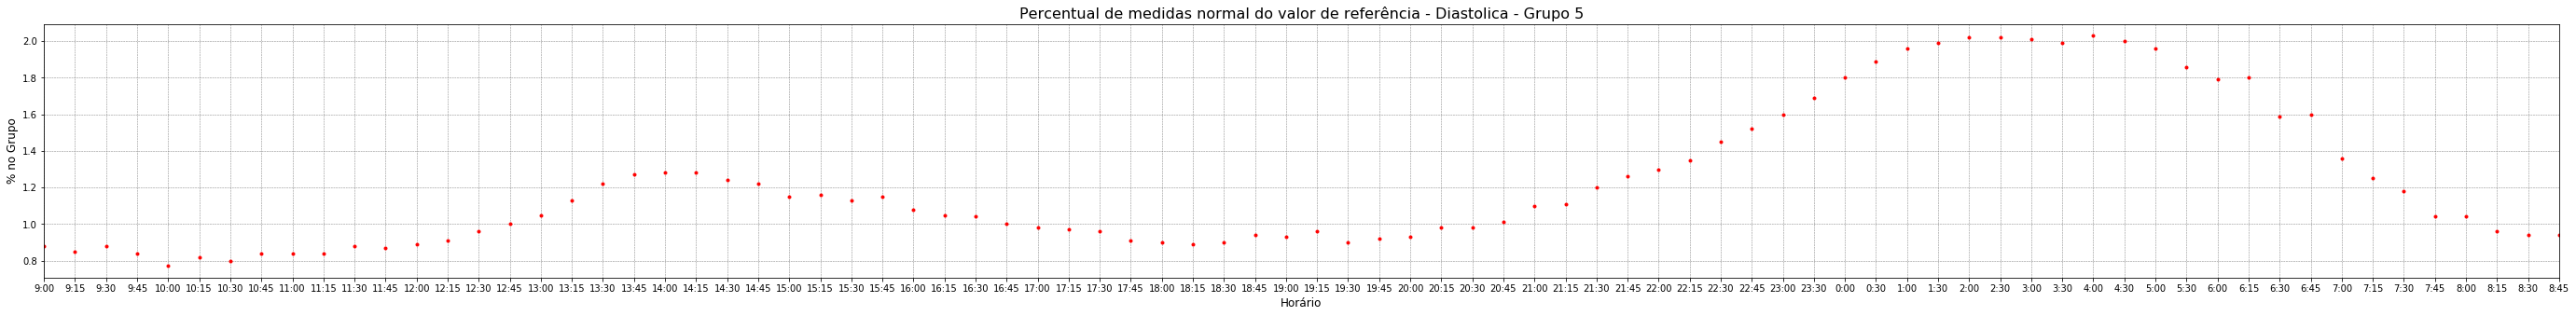

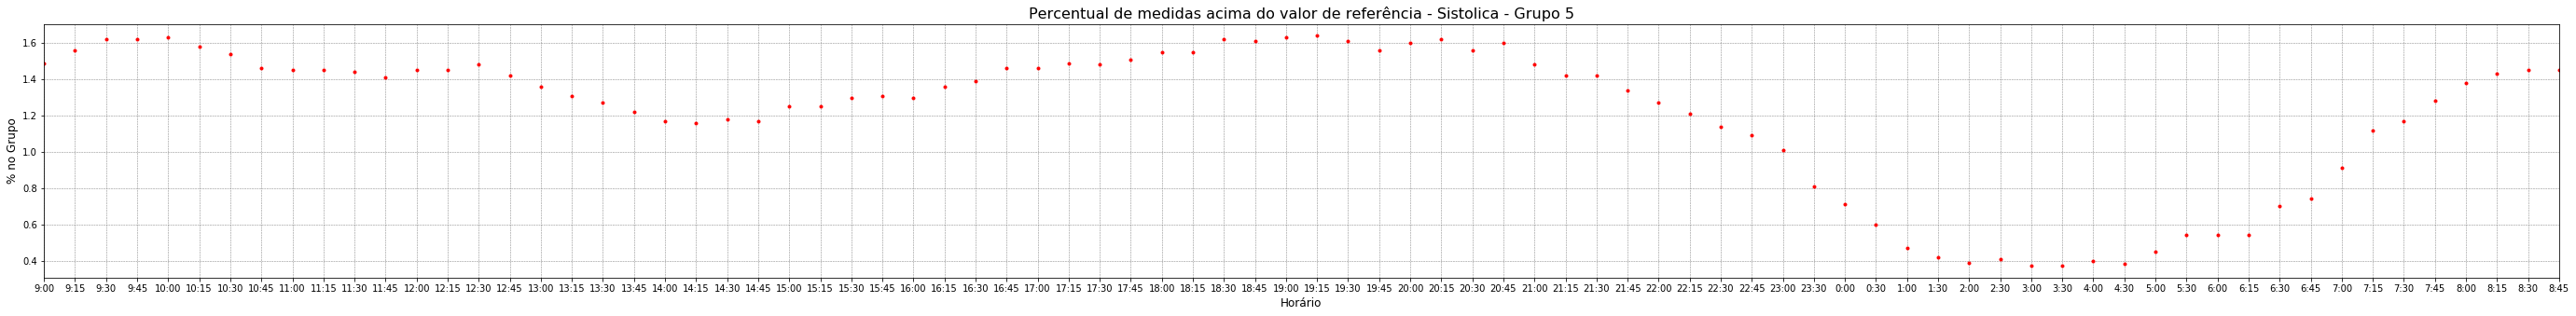

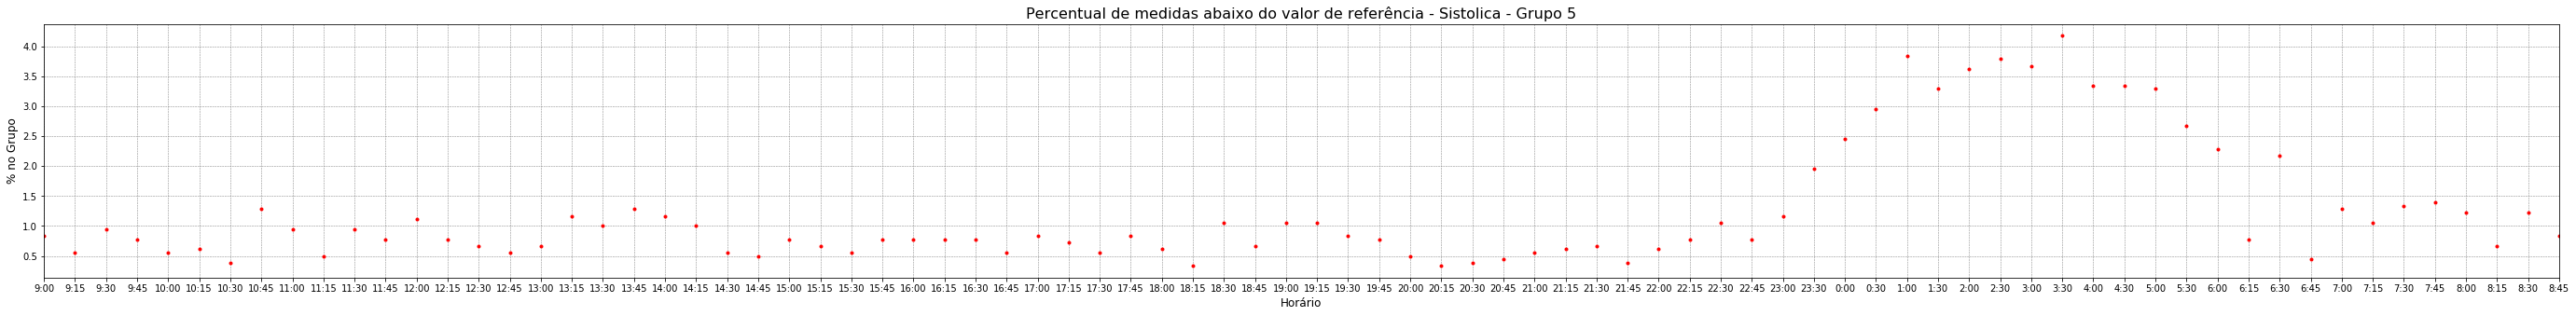

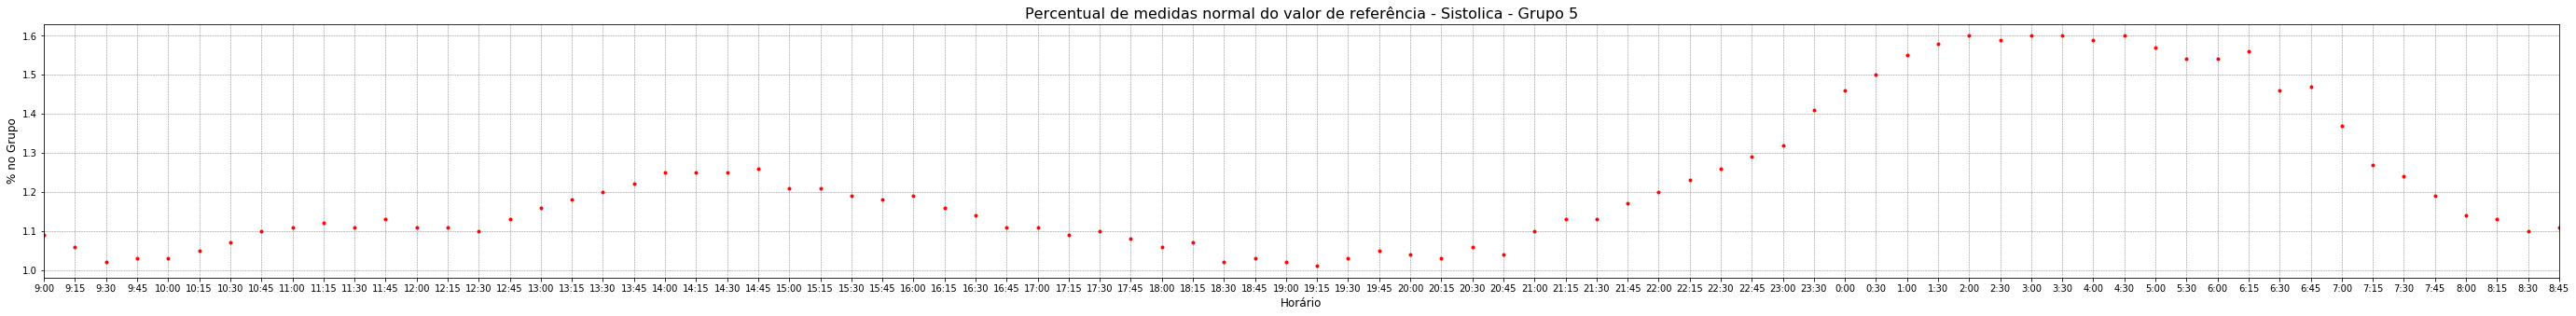

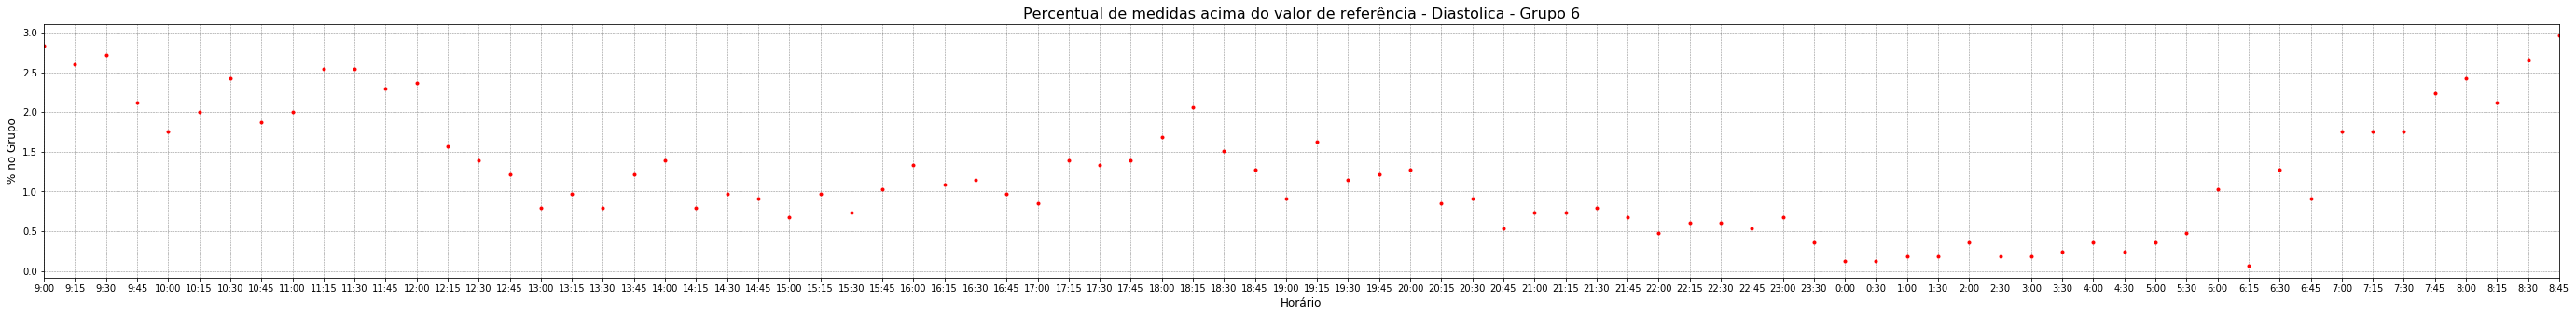

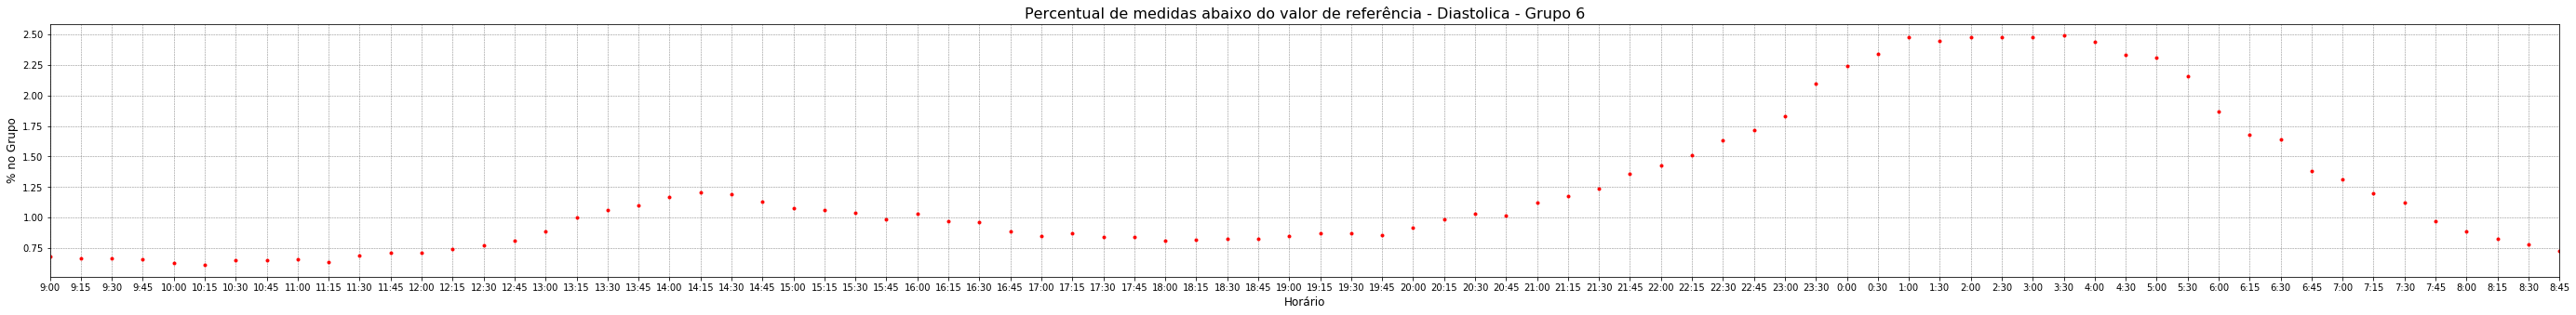

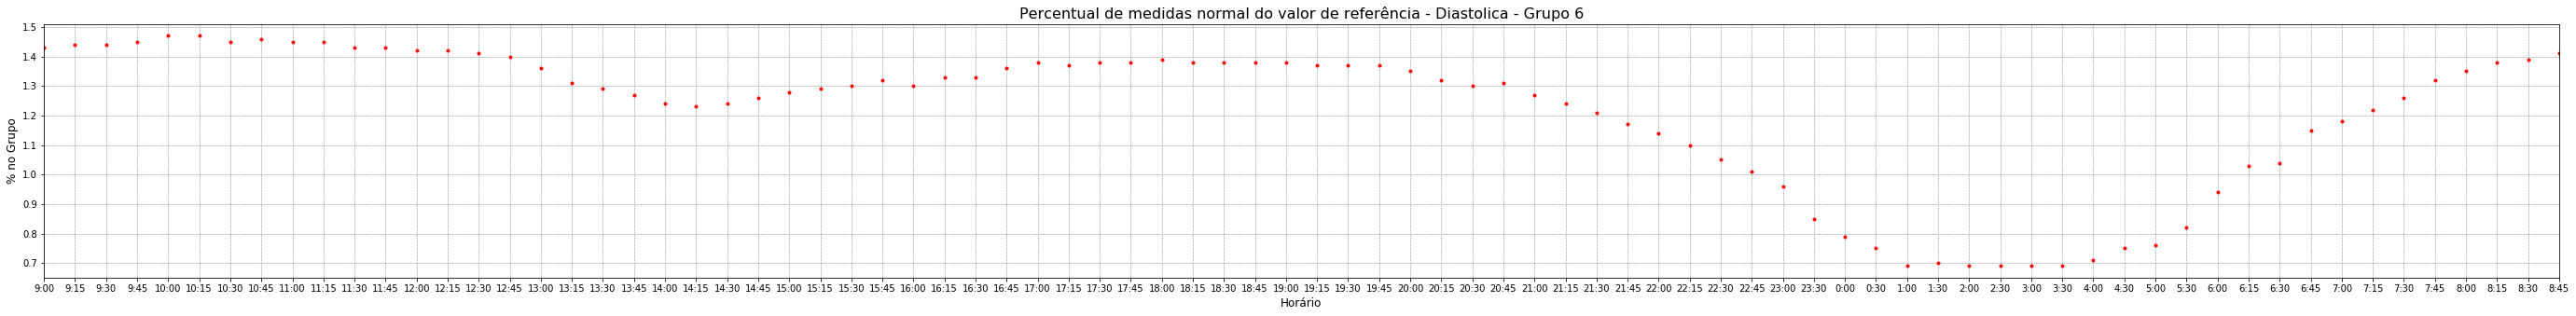

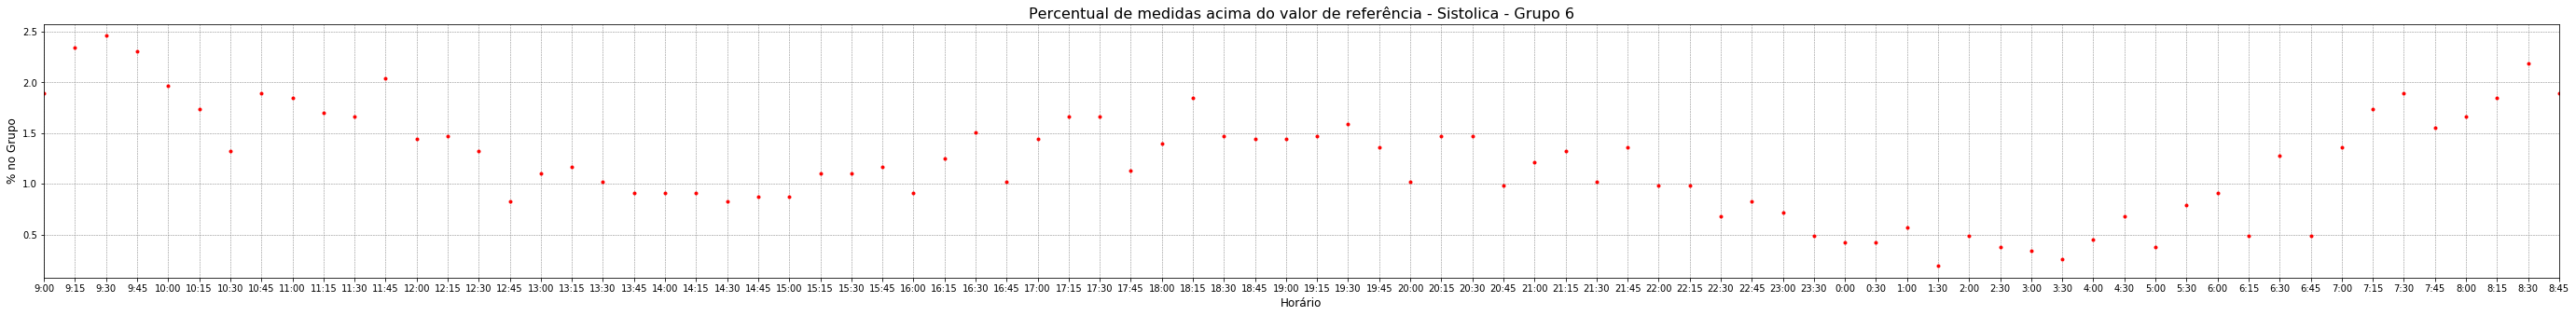

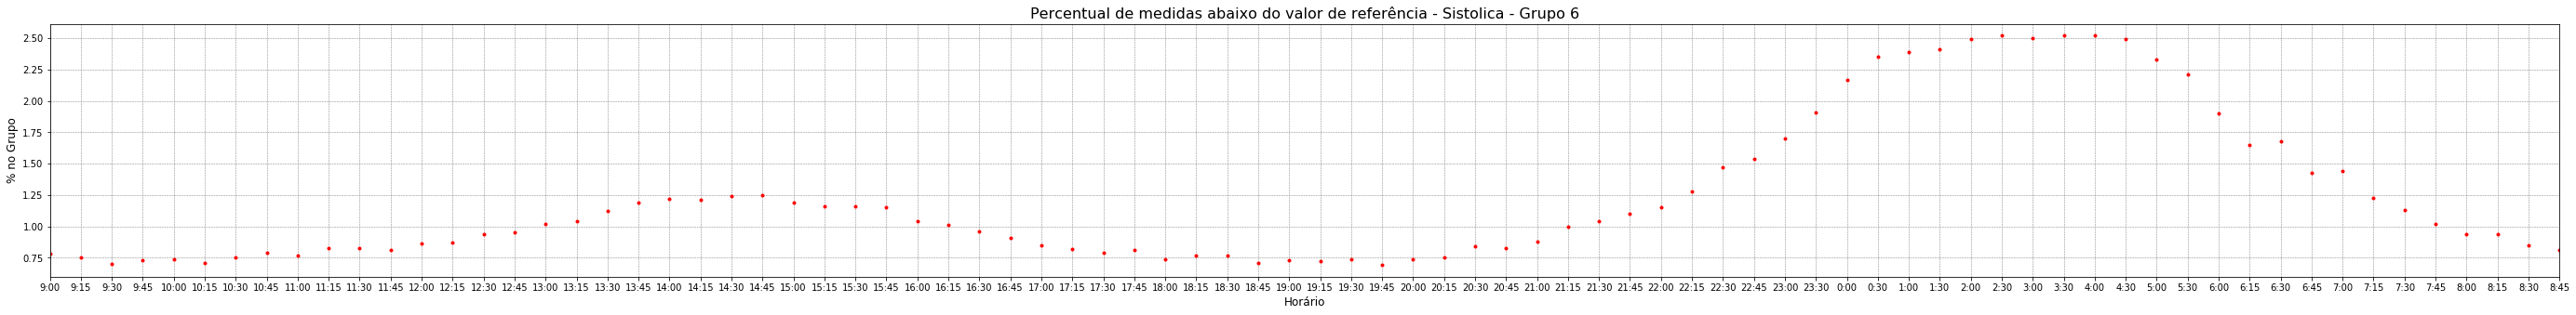

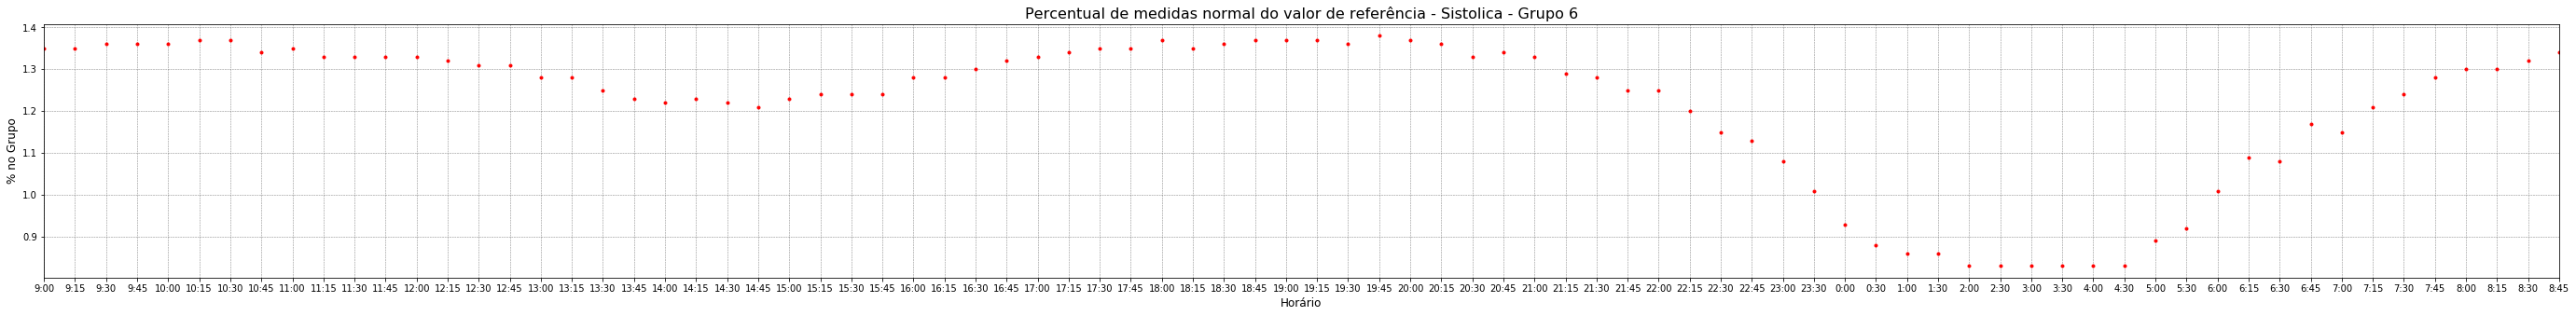

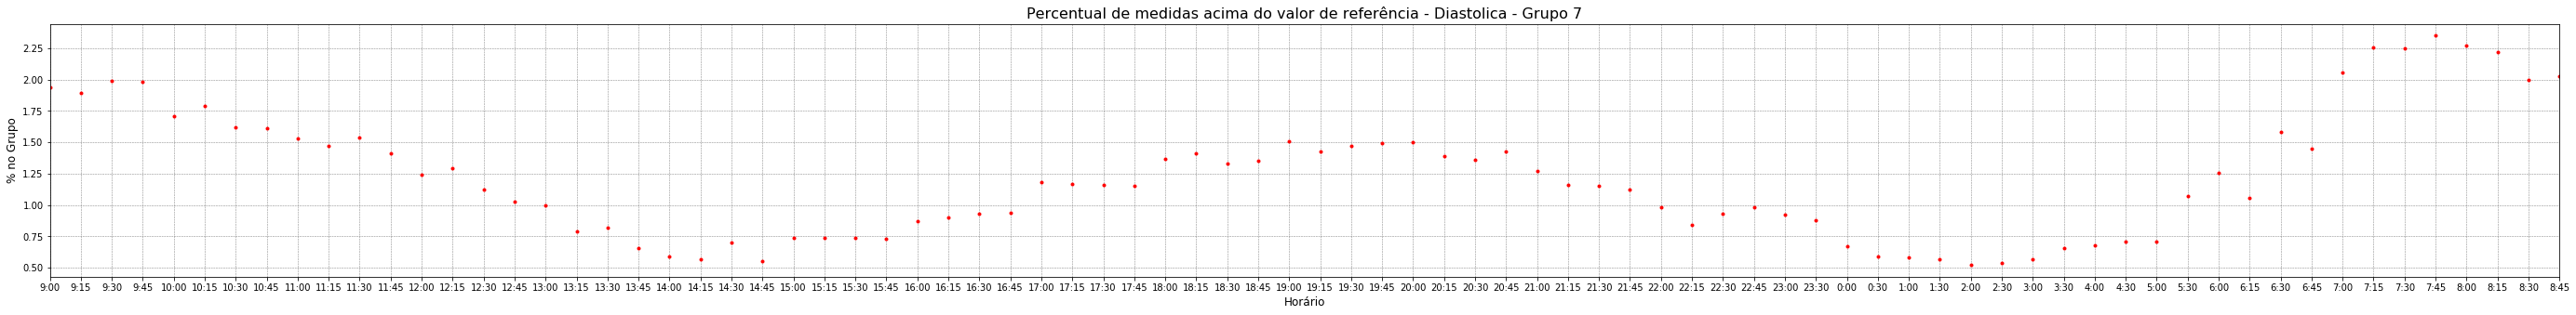

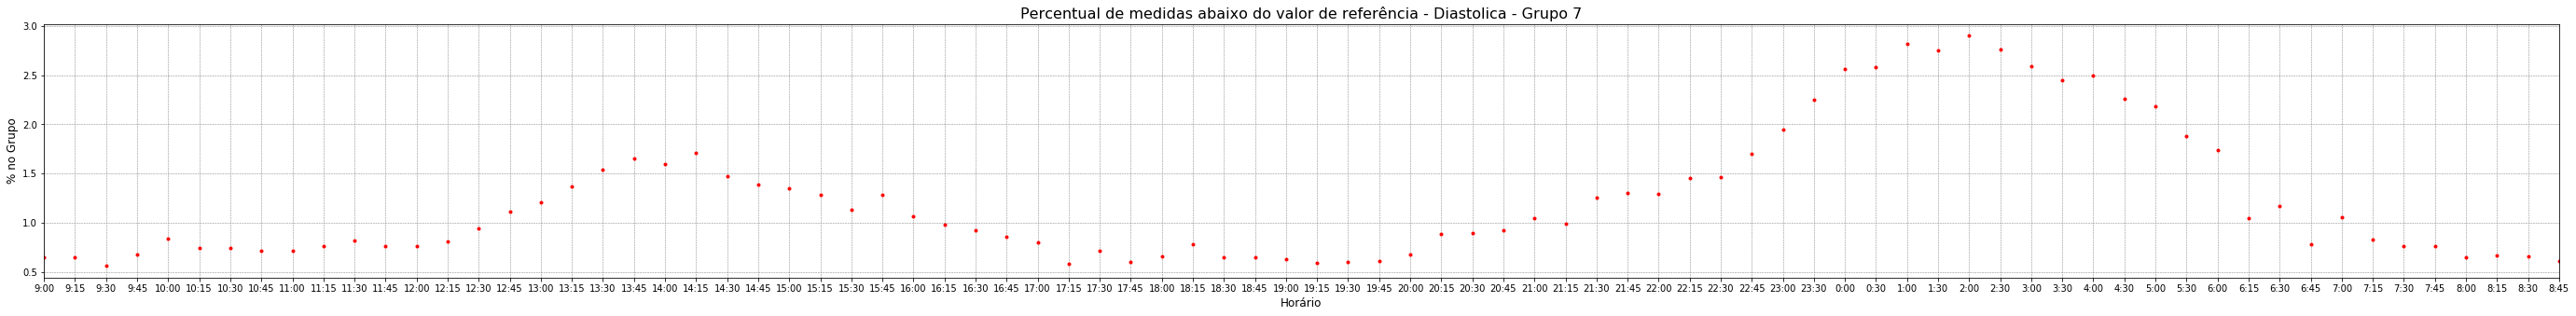

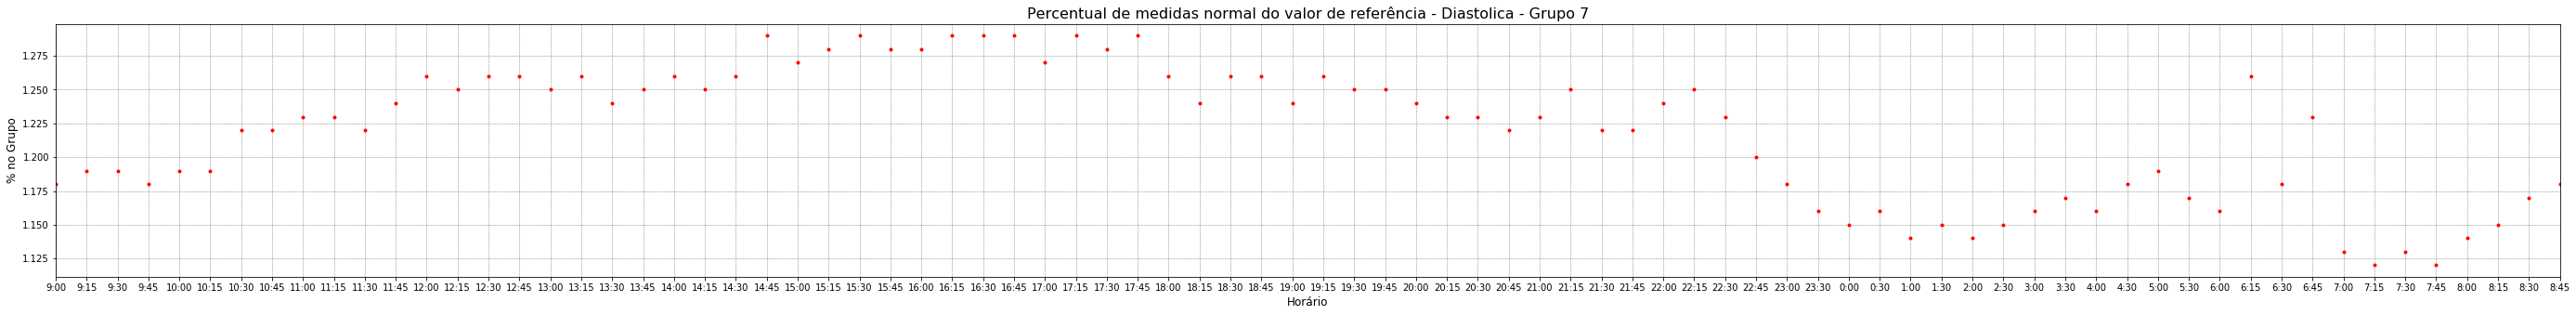

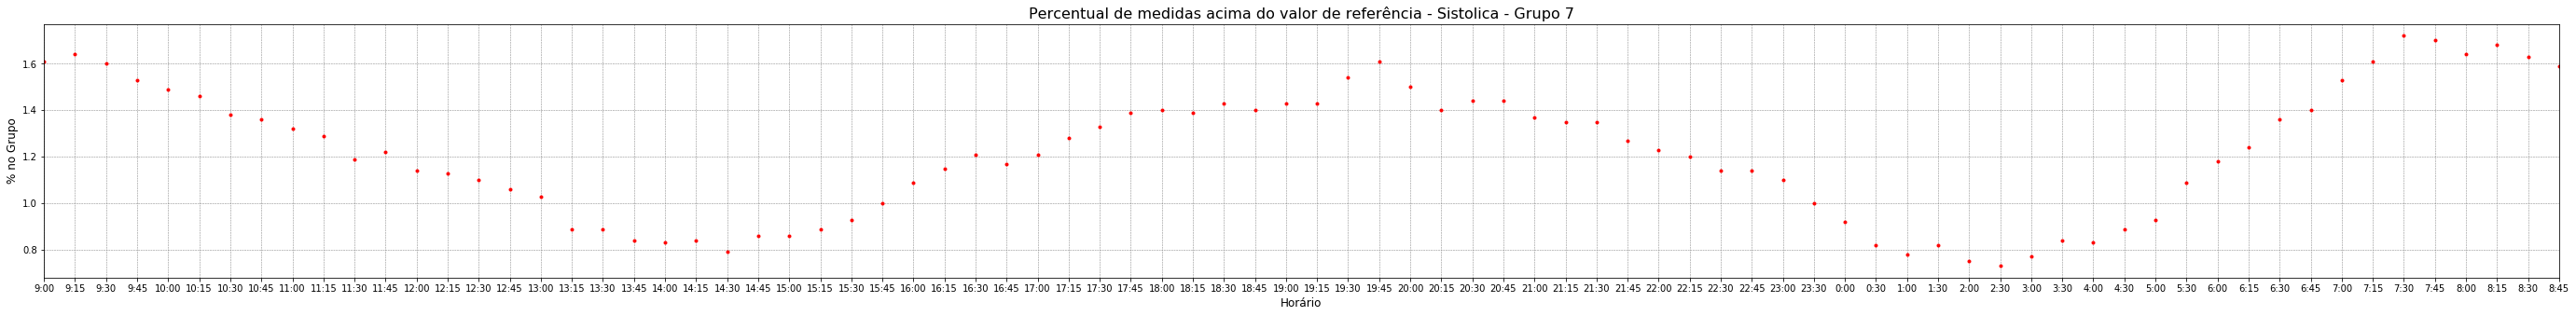

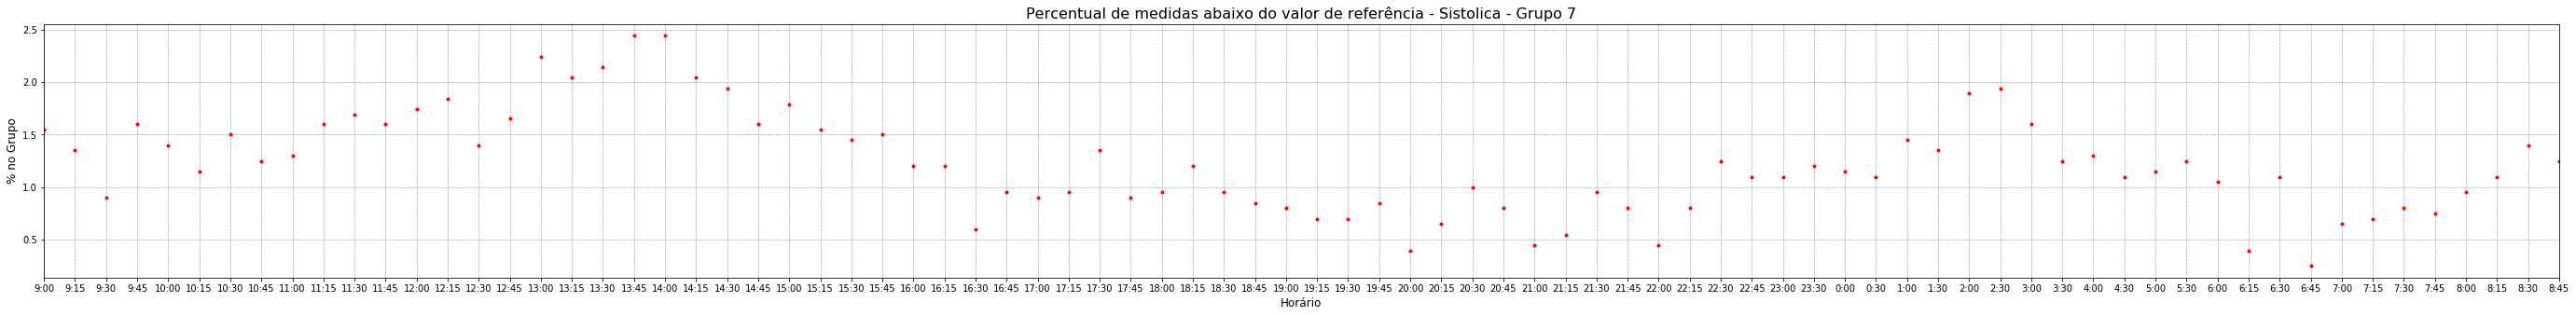

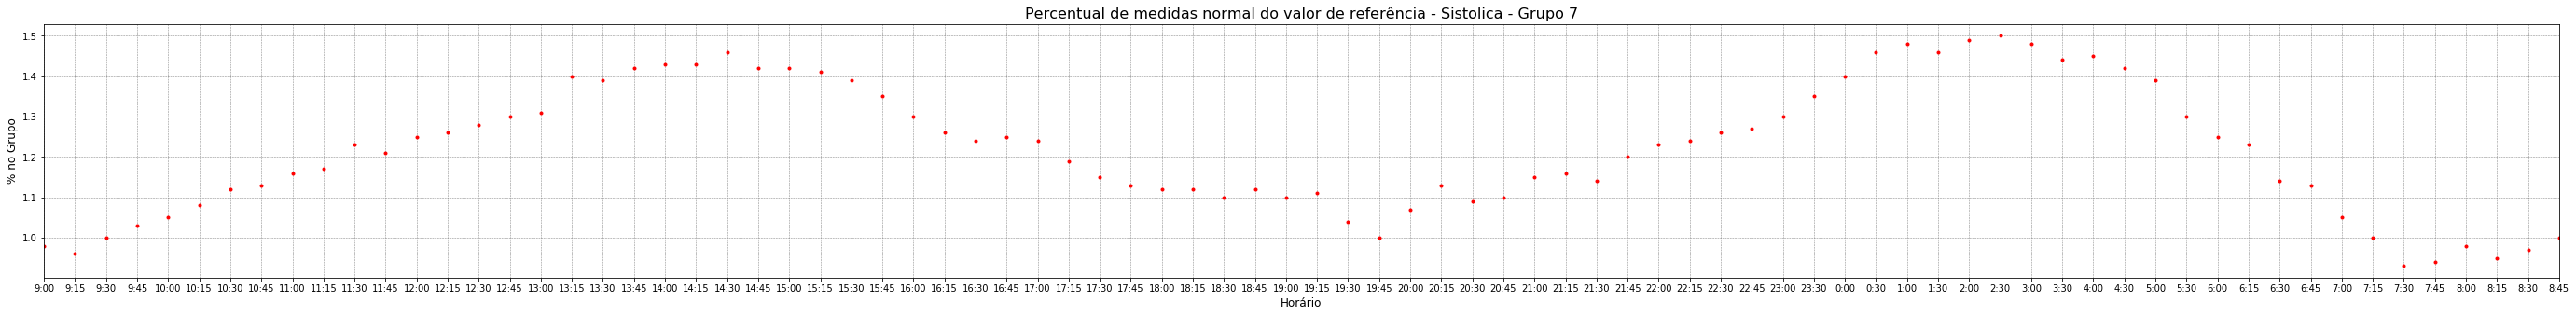

In [19]:
#ls_grupos_p
for grupo in range(len(lista_contagem)):
    
    grafico_percentual(ls_grupos_p[grupo][f'Horário - Grupo {grupo + 1}'],ls_grupos_p[grupo]['% Diast Max'], grupo + 1, 'Diastolica', 'acima')
    grafico_percentual(ls_grupos_p[grupo][f'Horário - Grupo {grupo + 1}'],ls_grupos_p[grupo]['% Diast Min'], grupo + 1, 'Diastolica', 'abaixo')
    grafico_percentual(ls_grupos_p[grupo][f'Horário - Grupo {grupo + 1}'],ls_grupos_p[grupo]['% Diast Normal'], grupo + 1, 'Diastolica', 'normal')
    
    grafico_percentual(ls_grupos_p[grupo][f'Horário - Grupo {grupo + 1}'],ls_grupos_p[grupo]['% Sist Max'], grupo + 1, 'Sistolica', 'acima')
    grafico_percentual(ls_grupos_p[grupo][f'Horário - Grupo {grupo + 1}'],ls_grupos_p[grupo]['% Sist Min'], grupo + 1, 'Sistolica', 'abaixo')
    grafico_percentual(ls_grupos_p[grupo][f'Horário - Grupo {grupo + 1}'],ls_grupos_p[grupo]['% Sist Normal'], grupo + 1, 'Sistolica', 'normal')

In [20]:
lista = [float(x.split(' ')[1].replace(':','.')) for x in df_abordagem.loc[:,'sist 9:00':'diast 8:45'].columns]
lista.sort()
dia = list()
noite = list()
for i in lista:
    if i >= 6 and i <= 22.45:
        dia.append(i)
    else:
        noite.append(i)
print(f'Dia: {len(dia)}\nNoite: {len(noite)}')

Dia: 136
Noite: 28


In [21]:
qtd_total_picos = np.sum(contagem_picos,axis=0).sort_values(ascending=False)
qtd_total_picos = qtd_total_picos.to_frame().reset_index()
qtd_total_picos.columns = ['Horário','QTD Picos Geral']
qtd_total_picos['%'] = np.round(qtd_total_picos['QTD Picos Geral'] / sum(qtd_total_picos['QTD Picos Geral']) * 100,3)
qtd_total_picos

##############################################??????????????????????????????????? Salvou?

,Horário,QTD Picos Geral,%
0,Sist 14:00 - 14:45 Normal,61567,1.960
1,Sist 15:00 - 15:45 Normal,61356,1.953
2,Sist 13:00 - 13:45 Normal,61285,1.951
3,Sist 16:00 - 16:45 Normal,61155,1.947
4,Sist 17:00 - 17:45 Normal,60806,1.936
...,...,...,...
139,Sist 2:00 - 2:30 Max,2529,0.081
140,Diast 4:00 - 4:30 Max,2015,0.064
141,Diast 1:00 - 1:30 Max,2013,0.064
142,Diast 3:00 - 3:30 Max,1885,0.060


In [22]:
#  Grava a quantidade de picos por cada período de tempo informado para calcular
#qtd_total_picos.to_csv ( DIR_SALVA / "frequencia_picos.csv", sep=";", encoding="latin1")

In [23]:
doencas = dataset.loc[:,'Hipotensao':'Normotenso']
cabecalho = doencas.columns

In [24]:
dataset[eval("(dataset['Hipotensao'] == True) & (dataset['Sistolica Isolada'] == True) & (dataset['Dipping'] == True) & (dataset['Morning Surge'] == True) & (dataset['Whitecoat'] == True)")]

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,data_exame,sist 9:00,sist 9:15,...,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica,Diferença % Dipping
7479,8399,1963-01-05,1,56.0,94.0,"1,73",31.4,2019-07-18 08:35:49,136.0,129.0,...,77.0,9630.0,6114.0,2938.0,539.5,11.46,8.68,4,0,1.110086


In [25]:
for n in range(2, 12):
    df_contagem_doencas = pd.DataFrame()
    for i in combinations(cabecalho,n):
        comando = ""
        coluna = ""
        for j in range(len(i)):
            if j == 0:
                comando += f"(doencas[{repr(i[j])}] == True)"
                coluna += f"{i[j]}"
            else:
                comando += f" & (doencas[{repr(i[j])}] == True)"
                coluna += f"&{i[j]}"

        df_contagem_doencas[coluna] = [len(doencas[eval(comando)])]
    df_contagem_doencas = df_contagem_doencas.T.sort_values(by=[0],ascending = False).reset_index()
    df_contagem_doencas.columns = ['Doencas','QTD']
    df_contagem_doencas
    lista.append(len(df_contagem_doencas))
    df_contagem_doencas.to_excel ( DIR_SALVA / "combinacao_doenca" / f"combinacao_{n}_doencas.xlsx", index = False)


In [26]:
n = 4
df_contagem_doencas = pd.DataFrame()
for i in combinations(cabecalho,n):
    comando = ""
    coluna = ""
    for j in range(len(i)):
        if j == 0:
            comando += f"(doencas[{repr(i[j])}] == True)"
            coluna += f"{i[j]}"
        else:
            comando += f" & (doencas[{repr(i[j])}] == True)"
            coluna += f"&{i[j]}"

    df_contagem_doencas[coluna] = [len(doencas[eval(comando)])]
    if(len(doencas[eval(comando)]) > 5):
        print(repr(comando))
df_contagem_doencas = df_contagem_doencas.T.sort_values(by=[0], ascending = False).reset_index()
df_contagem_doencas.columns = ['Doencas','QTD']
df_contagem_doencas

"(doencas['Hipotensao'] == True) & (doencas['Diastolica Isolada'] == True) & (doencas['Non Dipping'] == True) & (doencas['Whitecoat'] == True)"
"(doencas['Hipotensao'] == True) & (doencas['Dipping'] == True) & (doencas['Morning Surge'] == True) & (doencas['Whitecoat'] == True)"


,Doencas,QTD
0,Hipotensao&Dipping&Morning Surge&Whitecoat,2110
1,Hipotensao&Diastolica Isolada&Non Dipping&Whit...,15
2,Hipotensao&Diastolica Isolada&Dipping&Morning ...,2
3,Hipotensao&Diastolica Isolada&Reverse Dipping&...,2
4,Hipotensao&Sistolica Isolada&Non Dipping&White...,2
...,...,...
325,Hipotensao&Morning Surge&Masked&Whitecoat,0
326,Hipotensao&Reverse Dipping&Whitecoat&Normotenso,0
327,Hipotensao&Reverse Dipping&Masked&Normotenso,0
328,Hipotensao&Reverse Dipping&Masked&Whitecoat,0


In [27]:
busca = "(doencas['Hipotensao'] == True) & (doencas['Diastolica Isolada'] == True) & (doencas['Non Dipping'] == True) & (doencas['Whitecoat'] == True)"
ids = dataset[eval(busca.replace('doencas','dataset'))]['numero_identificacao']
ids

395        440
4378      4881
9000     10080
10369    11631
10506    11797
11402    12836
11455    12901
12575    14199
13870    15709
14049    15911
15416    17519
15979    18137
16405    18603
18650    21224
18683    21262
Name: numero_identificacao, dtype: int64